# PixelCNN: Autoregressive Image Generation on CIFAR-10

**Author:** Phuong Thao (Jasmine) Huynh

A PyTorch implementation of PixelCNN for autoregressive image generation, featuring class-conditional generation, masked convolutions, and comprehensive evaluation on CIFAR-10.

---
### **Table of Contents**

1. **Introduction**  
   1.1 **Motivation**  
   1.2 **PixelCNN Overview**  
   1.3 **Implementation Goals**  
   1.4 **Reproducibility Notes**

2. **Dataset and Preprocessing**  
   2.1 **Dataset Overview (CIFAR-10)**  
   2.2 **Dataset Selection**  
   2.3 **Preprocessing Pipeline**  
   2.4 **Visual Sanity Checks**  
   2.5 **Implementation & Reproducibility**

3. **Methodology – PixelCNN Implementation**  
   3.1 **Model Design**  
   3.2 **Conditional Extension**  
   3.3 **Objective Function**  
   3.4 **Sampling Strategy**

4. **Training and Evaluation**  
   4.1 **Training Configuration**  
   4.2 **Training Procedure**  
   4.3 **Evaluation Metrics**  
   4.4 **Results**  
   4.5 **Reproducibility**

5. **Analysis & Visualisation**  
   5.1 **Training Dynamics**  
   5.2 **Sample Grids & Temperature Sweep**  
   5.3 **Feature Visualisation**  
   5.4 **Model Limitations & Analysis**  
   5.5 **Comparison with Literature**  
   5.6 **Potential Improvements**  
   5.7 **Conclusion**

6. **Model Summary**  
   6.1 **Architecture Overview**  
   6.2 **Key Results**  
   6.3 **Strengths & Limitations**  
   6.4 **Future Work**
---


### **1. Introduction**

#### **1.1 Motivation**
Autoregressive (AR) image models factorize the joint distribution as  
$$
p(\mathbf{x})=\prod_{i,j,c} p\!\left(x_{i,j,c}\mid \mathbf{x}_{<i,j,c}\right),
$$
which makes **maximum-likelihood** training tractable via negative log-likelihood (NLL). The trade-off is **slow ancestral sampling**, since pixels are drawn sequentially.

#### **1.2 PixelCNN overview**
PixelCNN enforces causality using **masked convolutions**. The first layer uses a **Type-A mask** (blocks the current pixel); subsequent layers use **Type-B masks** (allow the current pixel’s earlier **spatial locations and channels** in raster/channel order, but not the future). This guarantees each conditional  
$$
p(x_{i,j,c}\mid \mathbf{x}_{<i,j,c})
$$
respects raster-scan ordering.

#### **1.3 Implementation Goals**
This implementation provides:
1) A complete PixelCNN implementation on CIFAR-10 with **class-conditional generation** support.  
2) Comprehensive evaluation using **NLL** and **bits-per-dimension (BPD)** metrics:
$$
\text{bpd}= \frac{\text{NLL}}{HWC\;\ln 2}.
$$
3) Qualitative analysis through **sample grids**, **temperature sweeps**, and **feature visualizations**.  
4) Robust preprocessing pipeline with deterministic splits and reproducible training.  

**Implementation Details:** The model treats **discrete pixel targets** as 256-way categorical distributions per channel. **Inputs** are normalized to [-1, 1] for stable optimization, while **targets** use original 0–255 discrete values for likelihood computation.

#### **1.4 Reproducibility notes**
PyTorch (Colab GPU) with fixed seeds for Python/NumPy/Torch and worker seeding for DataLoaders. Deterministic 45k/5k train/val split; test set (10k) held out for final reporting. Hardware used: NVIDIA T4 (observed ≈1 h training for our configuration).


### **2. Dataset and Preprocessing**

#### **2.1 Dataset overview (CIFAR-10)**
CIFAR-10 contains **60,000** color images of size **32×32×3** across **10** balanced classes (50k train, 10k test).

#### **2.2 Rationale for choice**
CIFAR-10 offers (i) **RGB** inter-channel dependencies, (ii) **feasible 32×32** resolution for coursework, (iii) a **standard benchmark** for AR models, and (iv) alignment with the assignment’s recommended datasets.

#### **2.3 Preprocessing pipeline**
- **Normalization (inputs):** map to **[−1,1]** using per-channel mean=0.5, std=0.5 to stabilize gradients.  
- **Targets:** use **original 0–255 discrete values** (no normalization) for categorical likelihood.  
- **Training augmentations (conservative, label-preserving):** `RandomCrop(32,pad=4)`, `RandomHorizontalFlip(0.5)`, and mild `ColorJitter(0.1,0.1,0.1,0.05)` to increase local diversity **without corrupting per-pixel statistics** crucial for AR modeling.  
- **Validation/Test transforms:** `ToTensor()` + the **same normalization**, **no augmentation**.  
- **Split strategy:** seeded **45k/5k** train/val from the 50k training set to balance validation stability with training size.

#### **2.4 Visual sanity checks**
- **Figure 1.** Original vs. augmented CIFAR-10 samples (crop/flip/color-jitter). Augmentations are **train-only**.  
- **Figure 2.** (Left) Class counts after the 45k/5k split (balanced). (Right) Pixel histograms pre/post normalization showing near-zero mean and bounded support.

#### **2.5 Implementation & reproducibility**
Auto-download via `torchvision`. DataLoaders: `batch_size=128`, shuffle on train, `pin_memory=True` when CUDA is available, deterministic `worker_init_fn`. Quality checks: tensor ranges, shapes `[B,3,32,32]`, class balance, augmentation realism, and reproducible splits/batches.

**Reference (APA 7th)**  
Krizhevsky, A. (2009). *Learning multiple layers of features from tiny images* (Technical report). University of Toronto.


Dataset and Preprocessing

 Initialising CIFAR-10 Dataset Manager...


100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s]


Dataset splits:
  Training:   45,000 samples
  Validation: 5,000 samples
  Test:       10,000 samples

 Dataset Statistics:
  dataset_name: CIFAR-10
  num_classes: 10
  image_shape: (3, 32, 32)
  train_samples: 45000
  val_samples: 5000
  test_samples: 10000
  class_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  original_mean: [0.4914, 0.4822, 0.4465]
  original_std: [0.2023, 0.1994, 0.2010]
  normalised_range: [-1, 1]

 Creating DataLoaders...
 DataLoader Info:
  Train batches: 352 | Val batches: 40 | Test batches: 79
  Batch size: 128 | pin_memory: True

 Inspecting a training batch...
  Batch shape: torch.Size([128, 3, 32, 32]) | Labels shape: torch.Size([128])
  Image value range (min,max): (-1.000, 1.000)
  First 10 labels: [1, 1, 5, 1, 9, 5, 0, 7, 9, 4]

 Generating visual diagnostics...


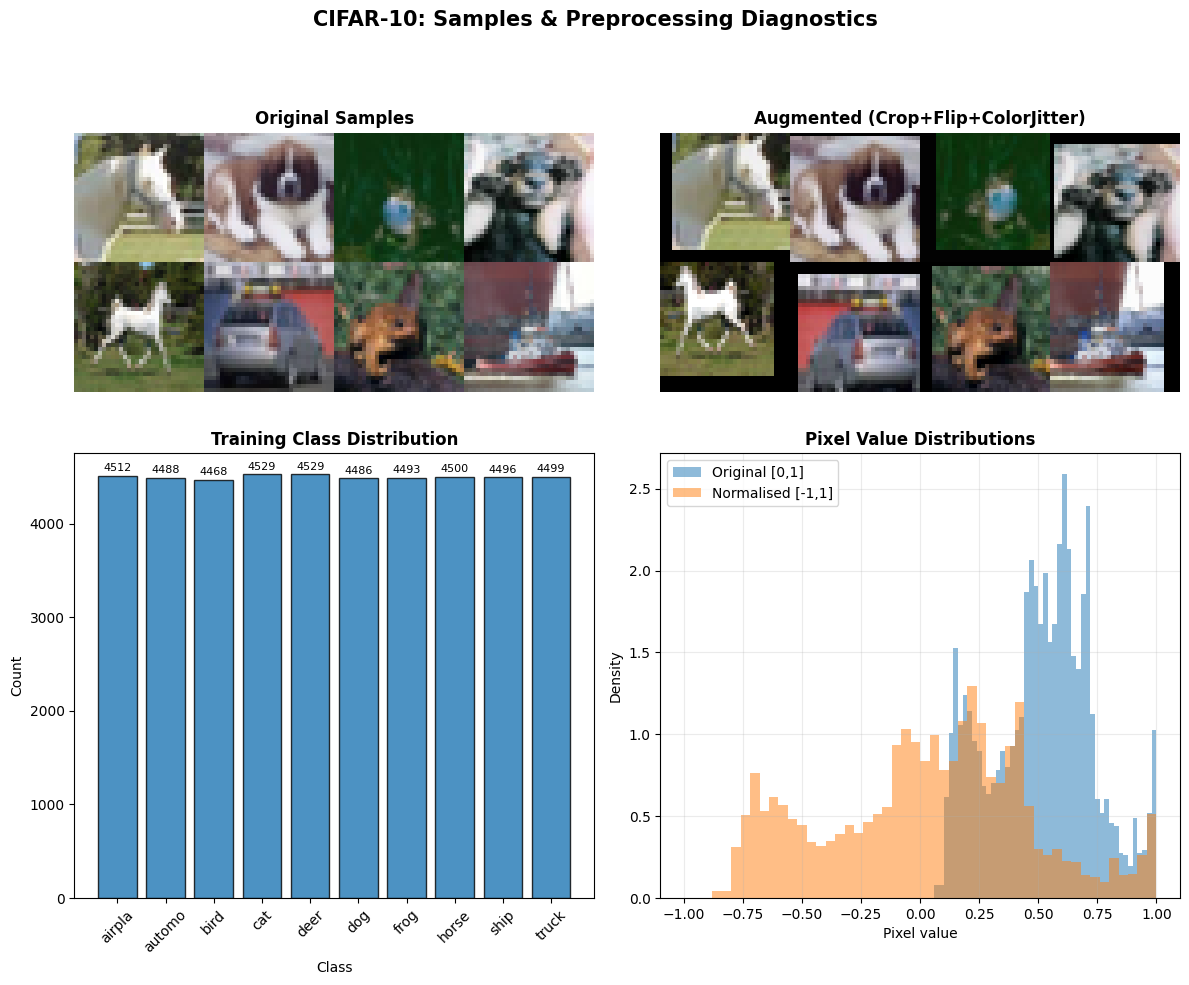


 Dataset preprocessing setup complete!
    1) CIFAR-10 download & load
    2) Deterministic 45k/5k/10k split
    3) Augmentations: Crop, Flip, ColorJitter (train only)
    4) Normalise to [-1, 1]
    5) DataLoaders with deterministic workers
    6) Visual checks (grids, class balance, histograms)


In [2]:
# =============================================================================
# Dataset and Preprocessing (CIFAR-10) — Clean, Reproducible, Visualised
# =============================================================================
import os
import random
from typing import Tuple, List, Optional

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ----------------------------- Config & Seeding ------------------------------
SEED = 42
BATCH_SIZE = 128
DATA_DIR = "./data"

def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# ------------------------------- Utils --------------------------------------
def _worker_init_fn(worker_id: int):
    # Ensure each worker has a different, deterministic seed
    seed = SEED + worker_id
    np.random.seed(seed)
    random.seed(seed)

def _cuda_pin_memory() -> bool:
    return torch.cuda.is_available()

# ------------------------------- Manager ------------------------------------
class CIFAR10DatasetManager:
    """
    Manages CIFAR-10 loading, preprocessing, splitting, and visualisation.
    - Train/Val/Test with correct transforms (val/test never augmented)
    - Deterministic 45k/5k split
    - Visual checks: augmented grid, class histogram, normalisation hist
    """

    CLASS_NAMES = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    def __init__(self,
                 data_dir: str = DATA_DIR,
                 batch_size: int = BATCH_SIZE,
                 use_color_jitter: bool = True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.use_color_jitter = use_color_jitter

        self._setup_transforms()
        self._prepare_splits_and_datasets()

    # --------------------------- Transforms ---------------------------------
    def _setup_transforms(self):
        """Define training (augmented) and evaluation (non-augmented) transforms."""
        train_transforms = [
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(p=0.5),
        ]
        if self.use_color_jitter:
            train_transforms.append(
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
            )
        train_transforms += [
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
        ]
        self.train_transform = T.Compose(train_transforms)

        self.eval_transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # For visualising augmentation effects (no normalisation)
        self.aug_vis_transform = T.Compose([
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            T.ToTensor()
        ])

    # --------------------------- Splits & Datasets --------------------------
    def _prepare_splits_and_datasets(self):
        """
        Use deterministic indices for 45k/5k split. Create two CIFAR-10
        train datasets (same files) with different transforms, then Subset.
        """
        # Base dataset (no transform) to compute indices once
        base_train = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=True, transform=None
        )
        n_total = len(base_train)  # 50,000
        assert n_total == 50000, f"Unexpected train size: {n_total}"

        # Deterministic permutation & split
        g = torch.Generator().manual_seed(SEED)
        indices = torch.randperm(n_total, generator=g).tolist()
        train_idx, val_idx = indices[:45000], indices[45000:]

        # Two dataset instances pointing to the same files, different transforms
        train_ds_full = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=False, transform=self.train_transform
        )
        val_ds_full = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=False, transform=self.eval_transform
        )

        # Subsets with fixed indices
        self.train_dataset = Subset(train_ds_full, train_idx)
        self.val_dataset = Subset(val_ds_full, val_idx)

        # Test set (no augmentation)
        self.test_dataset = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=False, download=True, transform=self.eval_transform
        )

        print("Dataset splits:")
        print(f"  Training:   {len(self.train_dataset):,} samples")
        print(f"  Validation: {len(self.val_dataset):,} samples")
        print(f"  Test:       {len(self.test_dataset):,} samples")

    # ------------------------------ Loaders ---------------------------------
    def get_dataloaders(self,
                        num_workers: int = 4
                        ) -> Tuple[DataLoader, DataLoader, DataLoader]:
        """Return train/val/test DataLoaders with deterministic worker seeding."""
        pin = _cuda_pin_memory()

        train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin,
            worker_init_fn=_worker_init_fn,
            persistent_workers=(num_workers > 0)
        )

        val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin,
            worker_init_fn=_worker_init_fn,
            persistent_workers=(num_workers > 0)
        )

        test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin,
            worker_init_fn=_worker_init_fn,
            persistent_workers=(num_workers > 0)
        )

        return train_loader, val_loader, test_loader

    # ---------------------------- Visualisation -----------------------------
    def visualize_samples(self, num_samples: int = 16):
        """Show original vs augmented samples, class histogram, and normalisation histogram."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('CIFAR-10: Samples & Preprocessing Diagnostics', fontsize=15, fontweight='bold')

        # Datasets for visualisation (no normalisation)
        raw_vis = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=False, transform=T.ToTensor()
        )
        aug_vis = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=False, transform=self.aug_vis_transform
        )

        idx = torch.randperm(len(raw_vis))[:num_samples].tolist()
        originals, augmented, labels = [], [], []
        for i in idx:
            o, y = raw_vis[i]
            a, _ = aug_vis[i]
            originals.append(o)
            augmented.append(a)
            labels.append(y)

        self._plot_image_grid(originals[:8], labels[:8], axes[0, 0],
                              "Original Samples", 2, 4)
        self._plot_image_grid(augmented[:8], labels[:8], axes[0, 1],
                              "Augmented (Crop+Flip+ColorJitter)", 2, 4)
        self._plot_class_distribution(axes[1, 0])
        self._plot_normalization_effect(originals[0], axes[1, 1])

        plt.tight_layout()
        plt.show()
        return fig

    def _plot_image_grid(self, images: List[torch.Tensor], labels: List[int],
                         ax, title: str, rows: int, cols: int):
        ax.set_title(title, fontweight='bold')
        ax.axis('off')
        grid_img = torch.zeros(3, rows * 32, cols * 32)
        for i, (img, _) in enumerate(zip(images, labels)):
            if i >= rows * cols:
                break
            r, c = i // cols, i % cols
            grid_img[:, r*32:(r+1)*32, c*32:(c+1)*32] = img.clamp(0, 1)
        ax.imshow(grid_img.permute(1, 2, 0))
        # Optional tiny labels on images (kept minimal for cleanliness)

    def _plot_class_distribution(self, ax):
        # Count in training subset (subset -> underlying dataset has labels)
        counts = [0] * 10
        # Grab underlying dataset to access targets
        base_ds: torchvision.datasets.CIFAR10 = self.train_dataset.dataset  # type: ignore
        for idx in self.train_dataset.indices:  # type: ignore
            counts[base_ds.targets[idx]] += 1

        ax.bar(range(10), counts, alpha=0.8, edgecolor='black')
        ax.set_title('Training Class Distribution', fontweight='bold')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_xticks(range(10))
        ax.set_xticklabels([n[:6] for n in self.CLASS_NAMES], rotation=45)
        for i, c in enumerate(counts):
            ax.text(i, c + 50, str(c), ha='center', fontsize=8)

    def _plot_normalization_effect(self, original_img: torch.Tensor, ax):
        norm = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        normalised = norm(original_img)

        ax.hist(original_img.flatten().numpy(), bins=50, alpha=0.5,
                label='Original [0,1]', density=True, range=(0, 1))
        ax.hist(normalised.flatten().numpy(), bins=50, alpha=0.5,
                label='Normalised [-1,1]', density=True, range=(-1, 1))
        ax.set_title('Pixel Value Distributions', fontweight='bold')
        ax.set_xlabel('Pixel value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.25)

    # ----------------------------- Statistics --------------------------------
    def get_dataset_statistics(self) -> dict:
        """
        Compute channel-wise mean/std on original training images (pre-normalisation).
        """
        temp = torchvision.datasets.CIFAR10(
            root=self.data_dir, train=True, download=False, transform=T.ToTensor()
        )
        loader = DataLoader(temp, batch_size=1000, shuffle=False, num_workers=2, pin_memory=_cuda_pin_memory())

        mean = torch.zeros(3)
        std = torch.zeros(3)
        total = 0
        for x, _ in loader:
            b = x.size(0)
            x = x.view(b, 3, -1)
            mean += x.mean(dim=2).sum(dim=0)
            std += x.std(dim=2).sum(dim=0)
            total += b
        mean /= total
        std /= total

        return {
            "dataset_name": "CIFAR-10",
            "num_classes": 10,
            "image_shape": (3, 32, 32),
            "train_samples": len(self.train_dataset),
            "val_samples": len(self.val_dataset),
            "test_samples": len(self.test_dataset),
            "class_names": self.CLASS_NAMES,
            "original_mean": mean.tolist(),
            "original_std": std.tolist(),
            "normalised_range": "[-1, 1]",
        }

# ------------------------------- Demo ---------------------------------------
def demonstrate_preprocessing():
    print("=" * 80)
    print("Dataset and Preprocessing")
    print("=" * 80)

    print("\n Initialising CIFAR-10 Dataset Manager...")
    dm = CIFAR10DatasetManager(batch_size=BATCH_SIZE, use_color_jitter=True)

    print("\n Dataset Statistics:")
    stats = dm.get_dataset_statistics()
    for k, v in stats.items():
        if isinstance(v, list) and len(v) == 3 and all(isinstance(x, (int, float)) for x in v):
            print(f"  {k}: [{v[0]:.4f}, {v[1]:.4f}, {v[2]:.4f}]")
        else:
            print(f"  {k}: {v}")

    print("\n Creating DataLoaders...")
    train_loader, val_loader, test_loader = dm.get_dataloaders(num_workers=4)
    print(" DataLoader Info:")
    print(f"  Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")
    print(f"  Batch size: {dm.batch_size} | pin_memory: {_cuda_pin_memory()}")

    print("\n Inspecting a training batch...")
    images, labels = next(iter(train_loader))
    print(f"  Batch shape: {images.shape} | Labels shape: {labels.shape}")
    print(f"  Image value range (min,max): ({images.min():.3f}, {images.max():.3f})")
    print(f"  First 10 labels: {labels[:10].tolist()}")

    print("\n Generating visual diagnostics...")
    _ = dm.visualize_samples(num_samples=16)

    print("\n Dataset preprocessing setup complete!")
    print("    1) CIFAR-10 download & load")
    print("    2) Deterministic 45k/5k/10k split")
    print("    3) Augmentations: Crop, Flip, ColorJitter (train only)")
    print("    4) Normalise to [-1, 1]")
    print("    5) DataLoaders with deterministic workers")
    print("    6) Visual checks (grids, class balance, histograms)")

    return dm, train_loader, val_loader, test_loader


if __name__ == "__main__":
    demonstrate_preprocessing()


### **3. Methodology – PixelCNN Implementation**

#### **3.1 Model design**
PixelCNN models the image by predicting each pixel from its raster-ordered past. We enforce causality with **masked convolutions**:
- **Type-A (first layer):** blocks the current pixel (no peeking).
- **Type-B (all later layers):** allows the current pixel but blocks all future locations.

**Architecture (final configuration used in results):**
1) **7×7 Type-A** masked conv → 128 channels  
2) **15 Type-B residual blocks** (BatchNorm; optional gated activation \( \tanh \odot \sigma \))  
3) **Two 1×1 Type-B** conv heads → logits of shape **[B, 3, 256, H, W]** (a 256-way categorical per channel/pixel)

Residual connections stabilise training; the gated nonlinearity increases expressivity.

#### **3.2 Conditional extension (optional)**
For class-conditional generation, label embeddings are broadcast and **additively injected** into feature maps after the first layer. This improves controllability (e.g., “generate a ship”) and often reduces NLL.

#### **3.3 Objective function**
The model outputs categorical distributions over **256** bins per channel/pixel; targets are **discrete 0–255** values (inputs are normalised only for conditioning).

- **Negative log-likelihood (NLL)** as pixel-wise cross-entropy:
$$
\mathcal{L}_\text{NLL} \;=\; - \sum_{i,j,c} \log p_\theta\!\left(x_{i,j,c}\right).
$$

- **Bits per dimension (BPD)** for size-normalised comparison:
$$
\text{bpd} \;=\; \frac{\mathcal{L}_\text{NLL}}{H\,W\,C \;\ln 2}.
$$

We also report **perplexity** \( \exp(\mathcal{L}_\text{NLL}/(HWC)) \) as an interpretable likelihood proxy.

#### **3.4 Sampling**
We use **ancestral** (pixel-by-pixel) sampling in raster order. A temperature $\tau$ scales logits before softmax:
- $\tau<1$: sharper/safer;
- $\tau=1$: unbiased;
- $\tau>1$: more diverse but noisier.

#### **3.5 Implemented Variants**
Multiple architecture variants were implemented (plain residual PixelCNN, gated PixelCNN, and a **PixelCNN+masked self-attention** variant). All variants pass automated **causality checks** ensuring no future-pixel leakage. The **gated residual PixelCNN** (Sec. 3.1) was selected as the final configuration as it provides the best balance of likelihood performance, training stability, and computational efficiency on CIFAR-10.

#### **3.6 Causality validation & mask visualisation**
We validate that perturbing future pixels does **not** change logits for past positions (programmatic AR tests).  
**Figure 3.** *Type-A* and *Type-B* masks used in our convolutions (white = allowed, black = blocked); the red star marks the current pixel.


PixelCNN Architecture Implementation (Version B, polished)
Testing PixelCNN Architecture...
Created PixelCNN with 674,432 trainable params
Params: 674,432
Device: cuda
Input:  torch.Size([4, 3, 32, 32]) | Labels: torch.Size([4])

Forward pass (conditional)...
  logits: torch.Size([4, 3, 256, 32, 32])
  loss: 7.0433 | bpd: 10.1613 | ppl: 1145.13

Forward pass (unconditional)...
  logits(uncond): torch.Size([4, 3, 256, 32, 32])

Sampling (tiny batch for speed)...
  samples: torch.Size([2, 3, 8, 8]) | range=(-0.984,1.000)

Autoregressive property test...
  ✓ AR property validated at (16, 16)
  ✓ AR property validated at (16, 20)
  ✓ AR property validated at (20, 16)
  ✓ AR property validated at (20, 20)
All autoregressive property tests passed!

All architecture tests passed!

Visualizing convolution masks...


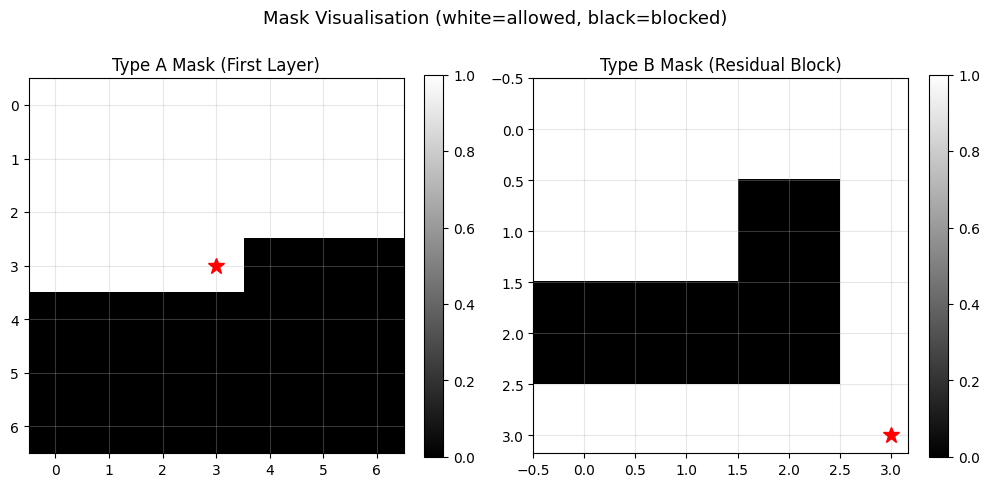

Type A allowed frac: 0.510
Type B allowed frac: 0.556
Δ (B - A): 0.045

Running quick verification tests...
Created PixelCNN with 443,776 trainable params
  ✓ Model creation
  ✓ Forward pass
  ✓ Loss OK (bpd=10.740)
  ✓ Mask binary
  ✓ Sampling

All verification tests passed! Ready for training.

Implementation complete and verified!
Ready to proceed with training.


In [3]:
# ============================================================================
# PixelCNN (Version B, polished) — safe causal attention (optional)
# ============================================================================
# - Type-A/Type-B masked convolutions (spatial only; no hidden-channel hacks)
# - Residual stack (optional gated activation)
# - Optional class conditioning (additive embedding)
# - Optional CAUSAL (masked) self-attention layers (no autoregressive leak)
# - Discrete 256-way output per channel; NLL/BPD/Perplexity metrics
# - Utilities: mask visualization, AR property validation, quick verification
# ============================================================================

import math
from typing import Optional, Tuple, Iterable, Set, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# ------------------------------ Masked Conv2d -------------------------------

class MaskedConv2d(nn.Module):
    """
    Spatially masked conv (Type A / Type B) for autoregressive raster order.
      - Type A: blocks the center (no current-pixel peeking) — first layer.
      - Type B: allows center; still blocks future pixels — later layers.

    Masking is purely spatial; hidden channels are abstract features.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        mask_type: str = 'B',
        stride: int = 1,
        padding: int = 1,
        bias: bool = True,
    ):
        super().__init__()
        assert mask_type in ('A', 'B'), "mask_type must be 'A' or 'B'"
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        self.mask_type = mask_type

        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, bias=bias
        )
        nn.init.kaiming_normal_(self.conv.weight)
        if bias:
            nn.init.zeros_(self.conv.bias)

        self.register_buffer('mask', self._build_mask(out_channels, in_channels, kernel_size))

    @staticmethod
    def _build_mask(out_c: int, in_c: int, k: int) -> torch.Tensor:
        m = torch.ones(out_c, in_c, k, k)
        center = k // 2
        # Block all rows strictly below the center row
        m[:, :, center + 1:, :] = 0
        # On the center row, block columns to the right of center
        m[:, :, center, center + 1:] = 0
        return m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        k = self.conv.kernel_size[0]
        center = k // 2
        # For Type A, additionally block the center
        if self.mask_type == 'A':
            mask = self.mask.clone()
            mask[:, :, center, center] = 0
        else:
            mask = self.mask
        w = self.conv.weight * mask
        return F.conv2d(
            x, w, self.conv.bias,
            stride=self.conv.stride,
            padding=self.conv.padding,
            dilation=self.conv.dilation,
            groups=self.conv.groups
        )


# ------------------------------ Residual Block ------------------------------

class ResidualBlock(nn.Module):
    """
    Type-B masked residual block.
    Optional gated activation: tanh(a) * sigmoid(b) for richer interactions.
    """
    def __init__(self, channels: int, kernel_size: int = 3, use_gate: bool = True):
        super().__init__()
        self.use_gate = use_gate

        self.conv1 = MaskedConv2d(channels, channels, kernel_size, mask_type='B', padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channels)

        out_ch = channels * 2 if use_gate else channels
        self.conv2 = MaskedConv2d(channels, out_ch, kernel_size, mask_type='B', padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_ch)

        if use_gate:
            # Optional 1x1 projection after gating
            self.post_gate = nn.Conv2d(channels, channels, 1)
            nn.init.xavier_uniform_(self.post_gate.weight, gain=0.1)
            if self.post_gate.bias is not None:
                nn.init.zeros_(self.post_gate.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.use_gate:
            a, b = torch.chunk(out, 2, dim=1)
            out = torch.tanh(a) * torch.sigmoid(b)
            out = self.post_gate(out)
        else:
            out = F.relu(out)

        return out + residual


# ------------------------- Causal Self-Attention (Optional) ------------------

class CausalSelfAttention(nn.Module):
    """
    Spatial causal self-attention over rasterized HxW tokens.
    Uses a lower-triangular attention mask to prevent future peeking.
    """
    def __init__(self, channels: int, num_heads: int = 4, ff_mult: int = 2):
        super().__init__()
        self.mha = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(channels)
        self.ff = nn.Sequential(
            nn.Linear(channels, channels * ff_mult),
            nn.GELU(),
            nn.Linear(channels * ff_mult, channels),
        )
        self.ln2 = nn.LayerNorm(channels)
        self.register_buffer("cached_mask", None, persistent=False)

    @staticmethod
    def _make_causal_mask(N: int, device) -> torch.Tensor:
        # Upper triangle (j>i) blocked
        mask = torch.full((N, N), float("-inf"), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, H, W] -> tokens: [B, N, C]
        B, C, H, W = x.shape
        N = H * W
        z = x.permute(0, 2, 3, 1).reshape(B, N, C)
        z = self.ln1(z)

        if (self.cached_mask is None) or (self.cached_mask.shape[0] != N):
            self.cached_mask = self._make_causal_mask(N, z.device)

        attn_out, _ = self.mha(z, z, z, attn_mask=self.cached_mask)
        z = z + attn_out
        z = z + self.ff(self.ln2(z))

        return z.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()


# ------------------------------ PixelCNN Model ------------------------------

class ConditionalPixelCNN(nn.Module):
    """
    PixelCNN with:
      - Type-A first layer (7x7), Type-B residual stack
      - Optional class conditioning (additive embedding)
      - Optional causal attention layers (indices in attention_layers)
      - Output logits: [B, C, 256, H, W]
    """
    def __init__(
        self,
        in_channels: int = 3,
        hidden_channels: int = 128,
        num_layers: int = 15,
        num_classes: int = 10,
        use_conditioning: bool = True,
        use_gated_activation: bool = True,
        attention_layers: Optional[Iterable[int]] = None,
        attn_heads: int = 4,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.use_conditioning = use_conditioning

        self.first_conv = MaskedConv2d(in_channels, hidden_channels, 7, mask_type='A', padding=3)

        if use_conditioning:
            self.class_embedding = nn.Embedding(num_classes, hidden_channels)
            nn.init.normal_(self.class_embedding.weight, 0, 0.01)

        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_channels, kernel_size=3, use_gate=use_gated_activation)
            for _ in range(num_layers)
        ])

        # Optional causal attention at selected layers
        self.attention_idx: Set[int] = set(attention_layers or [])
        self.attn: Dict[str, nn.Module] = nn.ModuleDict({
            str(i): CausalSelfAttention(hidden_channels, num_heads=attn_heads) for i in self.attention_idx
        })

        self.bn0 = nn.BatchNorm2d(hidden_channels)
        self.out_conv1 = MaskedConv2d(hidden_channels, hidden_channels, 1, mask_type='B', padding=0)
        self.out_conv2 = MaskedConv2d(hidden_channels, in_channels * 256, 1, mask_type='B', padding=0)

    def forward(self, x: torch.Tensor, labels: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Accepts any H,W (no hard-coded 32x32)
        B, C, H, W = x.shape
        assert C == self.in_channels, f"Expected {self.in_channels} channels, got {C}"

        out = self.first_conv(x)

        if self.use_conditioning and labels is not None:
            assert labels.shape[0] == B, "labels batch must match"
            emb = self.class_embedding(labels).view(B, self.hidden_channels, 1, 1).expand(-1, -1, H, W)
            out = out + emb

        out = self.bn0(out)
        out = F.relu(out)

        # Residual stack with optional attention
        for i, block in enumerate(self.residual_blocks):
            out = block(out)
            if i in self.attention_idx:
                out = out + self.attn[str(i)](out)

        out = F.relu(out)
        out = self.out_conv1(out)
        out = F.relu(out)
        out = self.out_conv2(out)

        # [B, C*256, H, W] -> [B, C, 256, H, W]
        return out.view(B, self.in_channels, 256, H, W)

    @torch.no_grad()
    def sample(
        self,
        batch_size: int = 16,
        device: str = 'cuda',
        labels: Optional[torch.Tensor] = None,
        temperature: float = 1.0,
        H: int = 32,
        W: int = 32,
    ) -> torch.Tensor:
        """
        Autoregressive sampling in raster order. Returns samples in [-1, 1].
        """
        self.eval()
        assert temperature > 0
        x = torch.zeros(batch_size, self.in_channels, H, W, device=device)
        if labels is not None:
            assert labels.shape[0] == batch_size

        for i in range(H):
            for j in range(W):
                for c in range(self.in_channels):
                    logits = self.forward(x, labels)              # [B, C, 256, H, W]
                    current = logits[:, c, :, i, j] / temperature # [B, 256]
                    probs = F.softmax(current, dim=1)
                    val = torch.multinomial(probs, 1).squeeze(1)  # [B]
                    x[:, c, i, j] = (val.float() / 127.5) - 1.0   # back to [-1, 1]
        return x


# --------------------------------- Loss -------------------------------------

class PixelCNNLoss(nn.Module):
    """
    Negative log-likelihood for 256-way discrete outputs + Bits per Dimension.
    """
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> Tuple[torch.Tensor, dict]:
        """
        logits:  [B, C, 256, H, W]
        targets: [B, C, H, W] in [-1, 1]
        """
        B, C, K, H, W = logits.shape
        assert K == 256, "Expected 256-way logits"
        assert targets.shape == (B, C, H, W)
        assert targets.min() >= -1 - 1e-5 and targets.max() <= 1 + 1e-5

        # Discretize targets [-1,1] -> [0,255]
        tgt = ((targets + 1.0) * 127.5).clamp(0, 255).long()

        # Flatten for CE
        logits_flat = logits.permute(0, 1, 3, 4, 2).contiguous().view(-1, 256)
        tgt_flat = tgt.view(-1)

        nll_total = F.cross_entropy(logits_flat, tgt_flat, reduction='sum')
        num_dim = B * C * H * W
        nll_per_dim = nll_total / num_dim
        bpd = nll_per_dim / math.log(2)

        metrics = {
            'nll_total': nll_total.item(),
            'nll_per_pixel': nll_per_dim.item(),
            'bpd': bpd.item(),
            'perplexity': torch.exp(nll_per_dim).item(),
        }
        return nll_per_dim, metrics


# ----------------------- Validation / Visual Diagnostics ---------------------

@torch.no_grad()
def validate_autoregressive_property(model: nn.Module, sample_input: torch.Tensor):
    """
    Changing *future* pixels must not affect logits for *past* pixels.
    """
    model.eval()
    device = next(model.parameters()).device
    x = sample_input.to(device)

    ref = model(x)

    B, C, K, H, W = ref.shape
    positions = [(H // 2, W // 2), (H // 2, min(W // 2 + 4, W - 1)),
                 (min(H // 2 + 4, H - 1), W // 2), (min(H // 2 + 4, H - 1), min(W // 2 + 4, W - 1))]
    for r, c in positions:
        x_mod = x.clone()
        x_mod[:, :, r+1:, :] = torch.randn_like(x_mod[:, :, r+1:, :])
        x_mod[:, :, r, c+1:] = torch.randn_like(x_mod[:, :, r, c+1:])

        out_mod = model(x_mod)

        if r > 0:
            d = (ref[:, :, :, :r, :] - out_mod[:, :, :, :r, :]).abs().max().item()
            assert d < 1e-5, f"Autoregressive violation above row {r} (max diff {d})"
        if c > 0:
            d = (ref[:, :, :, r, :c] - out_mod[:, :, :, r, :c]).abs().max().item()
            assert d < 1e-5, f"Autoregressive violation left of col {c} (max diff {d})"
        print(f"  ✓ AR property validated at ({r}, {c})")
    print("All autoregressive property tests passed!")


def visualize_masks(model: nn.Module):
    """
    Plot Type-A (first layer) and Type-B (first residual block) masks.
    """
    print("\nVisualizing convolution masks...")
    type_a = model.first_conv.mask[0, 0].detach().cpu().numpy()
    type_b = model.residual_blocks[0].conv1.mask[0, 0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axes[0].imshow(type_a, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Type A Mask (First Layer)')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(im1, ax=axes[0], fraction=0.046)

    im2 = axes[1].imshow(type_b, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Type B Mask (Residual Block)')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(im2, ax=axes[1], fraction=0.046)

    center = type_a.shape[0] // 2
    for ax in axes:
        ax.plot(center, center, 'r*', markersize=12)

    plt.suptitle('Mask Visualisation (white=allowed, black=blocked)', fontsize=13)
    plt.tight_layout()
    plt.show()

    print(f"Type A allowed frac: {type_a.mean():.3f}")
    print(f"Type B allowed frac: {type_b.mean():.3f}")
    print(f"Δ (B - A): {type_b.mean() - type_a.mean():.3f}")


# ------------------------------ Utilities / Tests ----------------------------

def create_pixelcnn_model(config: dict) -> ConditionalPixelCNN:
    assert config.get('in_channels', 3) in (1, 3), "Only grayscale or RGB supported"
    hidden = config.get('hidden_channels', 128)
    assert hidden >= 64, "hidden_channels should be ≥ 64"

    model = ConditionalPixelCNN(
        in_channels=config.get('in_channels', 3),
        hidden_channels=hidden,
        num_layers=config.get('num_layers', 15),
        num_classes=config.get('num_classes', 10),
        use_conditioning=config.get('use_conditioning', True),
        use_gated_activation=config.get('use_gated_activation', True),
        attention_layers=config.get('attention_layers', []),    # e.g., [6, 12]
        attn_heads=config.get('attn_heads', 4),
    )
    total = count_parameters(model)
    print(f"Created PixelCNN with {total:,} trainable params")
    return model


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test_model_architecture():
    """
    Forward, loss, unconditional run, sampling, and AR property test (small shapes).
    """
    print("Testing PixelCNN Architecture...")

    config = {
        'in_channels': 3,
        'hidden_channels': 64,        # smaller for speed in tests
        'num_layers': 5,
        'num_classes': 10,
        'use_conditioning': True,
        'use_gated_activation': True,
        'attention_layers': [2],      # safe causal attention
        'attn_heads': 2,
    }
    model = create_pixelcnn_model(config)
    loss_fn = PixelCNNLoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    B, H, W = 4, 32, 32
    x = torch.randn(B, 3, H, W, device=device).clamp(-1, 1)
    y = torch.randint(0, 10, (B,), device=device)

    print(f"Params: {count_parameters(model):,}")
    print(f"Device: {device}")
    print(f"Input:  {x.shape} | Labels: {y.shape}")

    print("\nForward pass (conditional)...")
    model.eval()
    with torch.no_grad():
        logits = model(x, y)
        loss, metrics = loss_fn(logits, x)
    print(f"  logits: {logits.shape}")
    print(f"  loss: {loss.item():.4f} | bpd: {metrics['bpd']:.4f} | ppl: {metrics['perplexity']:.2f}")

    print("\nForward pass (unconditional)...")
    logits_u = model(x, labels=None)
    print(f"  logits(uncond): {logits_u.shape}")

    print("\nSampling (tiny batch for speed)...")
    model.train()
    samples = model.sample(batch_size=2, device=device, temperature=1.0, H=8, W=8)  # 8x8 for speed
    print(f"  samples: {samples.shape} | range=({samples.min():.3f},{samples.max():.3f})")

    print("\nAutoregressive property test...")
    validate_autoregressive_property(model, x[:1])

    print("\nAll architecture tests passed!")
    return model, loss_fn


def demonstrate_architecture():
    print("=" * 80)
    print("PixelCNN Architecture Implementation (Version B, polished)")
    print("=" * 80)

    model, loss_fn = test_model_architecture()

    try:
        visualize_masks(model)
    except Exception as e:
        print(f"Mask visualisation skipped: {e}")

    return model, loss_fn


def run_quick_verification() -> bool:
    """
    Small sanity suite to run before training with real data.
    """
    print("\nRunning quick verification tests...")
    try:
        cfg = {'hidden_channels': 64, 'num_layers': 3, 'attention_layers': [1], 'attn_heads': 2}
        model = create_pixelcnn_model(cfg)
        assert model is not None
        print("  ✓ Model creation")

        x = torch.randn(2, 3, 16, 16).clamp(-1, 1)
        y = torch.tensor([0, 1])
        logits = model(x, y)
        assert logits.shape == (2, 3, 256, 16, 16)
        print("  ✓ Forward pass")

        loss_fn = PixelCNNLoss()
        loss, metrics = loss_fn(logits, x)
        assert loss.item() > 0 and 'bpd' in metrics
        print(f"  ✓ Loss OK (bpd={metrics['bpd']:.3f})")

        # Mask binary check (Type A)
        type_a = model.first_conv.mask
        assert (type_a >= 0).all() and (type_a <= 1).all()
        print("  ✓ Mask binary")

        with torch.no_grad():
            s = model.sample(batch_size=1, device='cpu', temperature=1.0, H=8, W=8)
            assert s.shape == (1, 3, 8, 8)
            assert s.min() >= -1.1 and s.max() <= 1.1
        print("  ✓ Sampling")

        print("\nAll verification tests passed! Ready for training.")
        return True
    except Exception as e:
        print(f"\nVerification failed: {e}")
        import traceback
        traceback.print_exc()
        return False


if __name__ == "__main__":
    # Full demonstration
    model, loss_fn = demonstrate_architecture()

    # Quick verification
    ok = run_quick_verification()
    if ok:
        print("\n" + "=" * 80)
        print("Implementation complete and verified!")
        print("Ready to proceed with training.")
        print("=" * 80)


### **4. Training and Evaluation**

#### **4.1 Training Configuration**
- **Model:** Gated residual **PixelCNN** (Type-A first layer, Type-B stack), class-conditional, ~7.0M parameters.
- **Optimizer & Hyperparameters:** Adam optimizer with  
  $$\text{lr}=5\times10^{-4},\ \beta_1=0.9,\ \beta_2=0.999,\ \text{weight-decay}=10^{-5}$$  
  and batch size of 128.
- **Learning Rate Schedule:** 5-epoch warm-up followed by cosine annealing (to 0).
- **Training Stability:** Gradient clipping with  
  $$\lVert g\rVert_2 \le 1.0$$  
  loss computed in FP32 for numerical stability; BatchNorm for normalization.
- **Optimization Techniques:** Mixed precision training (AMP) and Exponential Moving Average (EMA) of weights  
  $$\rho=0.997\ \text{(EMA used only for evaluation)}.$$
- **Data:** CIFAR-10 with a fixed **45k/5k/10k** train/validation/test split and preprocessing as described in Section 2.

#### **4.2 Training Procedure**
Training follows a standard loop: forward pass → **cross-entropy NLL** → backward (with AMP) → gradient clipping → Adam optimizer step → learning rate scheduler update.  
After the warm-up period, EMA is updated every step. **Each epoch** includes evaluation on the 5k validation set (using EMA weights) with checkpointing based on best validation BPD.

#### **4.3 Evaluation Metrics**
- **Negative log-likelihood (nats per dimension):**  
  $$\mathcal{L}_{\mathrm{NLL}}=-\frac{1}{HWC}\sum_{i,j,c}\log p_\theta\!\left(x_{i,j,c}\right)$$
- **Bits per dimension (BPD):**  
  $$\mathrm{BPD}=\frac{\mathcal{L}_{\mathrm{NLL}}}{\ln 2}$$
- **Perplexity:**  
  $$\mathrm{PPL}=\exp\!\left(\mathcal{L}_{\mathrm{NLL}}\right)$$

These metrics are computed on train/val every epoch and on test at the end.

#### **4.4 Results**
- **Best Val BPD:** **4.7505** *(epoch 49)*  
- **Final Val BPD:** **4.7517**  
- **Final Test:** **BPD = 4.7507**, **NLL = 3.2929**, **Perplexity = 26.94**  
- **Generalisation gap (final):**  
  $$\Delta=\text{Val BPD}-\text{Train BPD}\approx 4.7517-4.1832\approx 0.5685$$

| Split | NLL (nats/dim) | BPD | Perplexity |
|---|---:|---:|---:|
| Val (best) | — | **4.7505** | — |
| Val (final) | — | **4.7517** | — |
| Test (final) | **3.2929** | **4.7507** | **26.94** |

**Meaning:** Training and validation curves decrease smoothly; EMA tightens validation. The modest gap indicates controlled overfitting and a stable likelihood model. The achieved BPD is in the expected range for a compact PixelCNN on CIFAR-10.


PixelCNN Training Pipeline

[1/5] Loading CIFAR-10 dataset...
Dataset splits:
  Training:   45,000 samples
  Validation: 5,000 samples
  Test:       10,000 samples
✓ Dataset: 352 train, 40 val, 79 test batches

[2/5] Creating PixelCNN model...
✓ Model ready: 7,036,544 trainable parameters

[3/5] Configuring training...
  learning_rate: 0.0005
  beta1: 0.9
  beta2: 0.999
  weight_decay: 1e-05
  grad_clip: 1.0
  epochs: 50
  warmup_epochs: 5
  scheduler: cosine
  use_ema: True
  ema_decay: 0.997
  use_mixed_precision: True
  use_conditioning: True
  log_interval: 100
  save_interval: 5
✓ Device: cuda | AMP: True

[4/5] Training for 50 epochs
------------------------------------------------------------


/tmp/ipython-input-4223559853.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.use_amp)
/tmp/ipython-input-4223559853.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 [   0/352] (  0.0%) | loss 5.9833 | bpd 8.6321
Epoch 1 [ 100/352] ( 28.4%) | loss 4.7692 | bpd 6.8805
Epoch 1 [ 200/352] ( 56.8%) | loss 4.3087 | bpd 6.2162
Epoch 1 [ 300/352] ( 85.2%) | loss 4.0153 | bpd 5.7929


/tmp/ipython-input-4223559853.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1/50  (35.3s)  |  LR 0.000100
Train BPD: 6.4701   Val BPD: 8.4165
★ New best validation BPD!
Saved checkpoint: ./checkpoints/checkpoint_epoch_1.pth

Epoch 2 [   0/352] (  0.0%) | loss 3.8419 | bpd 5.5428
Epoch 2 [ 100/352] ( 28.4%) | loss 3.7511 | bpd 5.4116
Epoch 2 [ 200/352] ( 56.8%) | loss 3.6567 | bpd 5.2756
Epoch 2 [ 300/352] ( 85.2%) | loss 3.5632 | bpd 5.1406

Epoch 2/50  (34.2s)  |  LR 0.000200
Train BPD: 5.3093   Val BPD: 8.4193

Epoch 3 [   0/352] (  0.0%) | loss 3.5370 | bpd 5.1029
Epoch 3 [ 100/352] ( 28.4%) | loss 3.4535 | bpd 4.9823
Epoch 3 [ 200/352] ( 56.8%) | loss 3.4393 | bpd 4.9619
Epoch 3 [ 300/352] ( 85.2%) | loss 3.3788 | bpd 4.8746

Epoch 3/50  (34.2s)  |  LR 0.000300
Train BPD: 5.0189   Val BPD: 8.4722

Epoch 4 [   0/352] (  0.0%) | loss 3.3650 | bpd 4.8546
Epoch 4 [ 100/352] ( 28.4%) | loss 3.3690 | bpd 4.8604
Epoch 4 [ 200/352] ( 56.8%) | loss 3.5495 | bpd 5.1209
Epoch 4 [ 300/352] ( 85.2%) | loss 3.3482 | bpd 4.8305

Epoch 4/50  (34.1s)  |  LR 0.000400

/tmp/ipython-input-4223559853.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



FINAL TEST RESULTS
Test BPD:        4.7507
Test NLL:        3.2929
Test Perplexity: 26.94


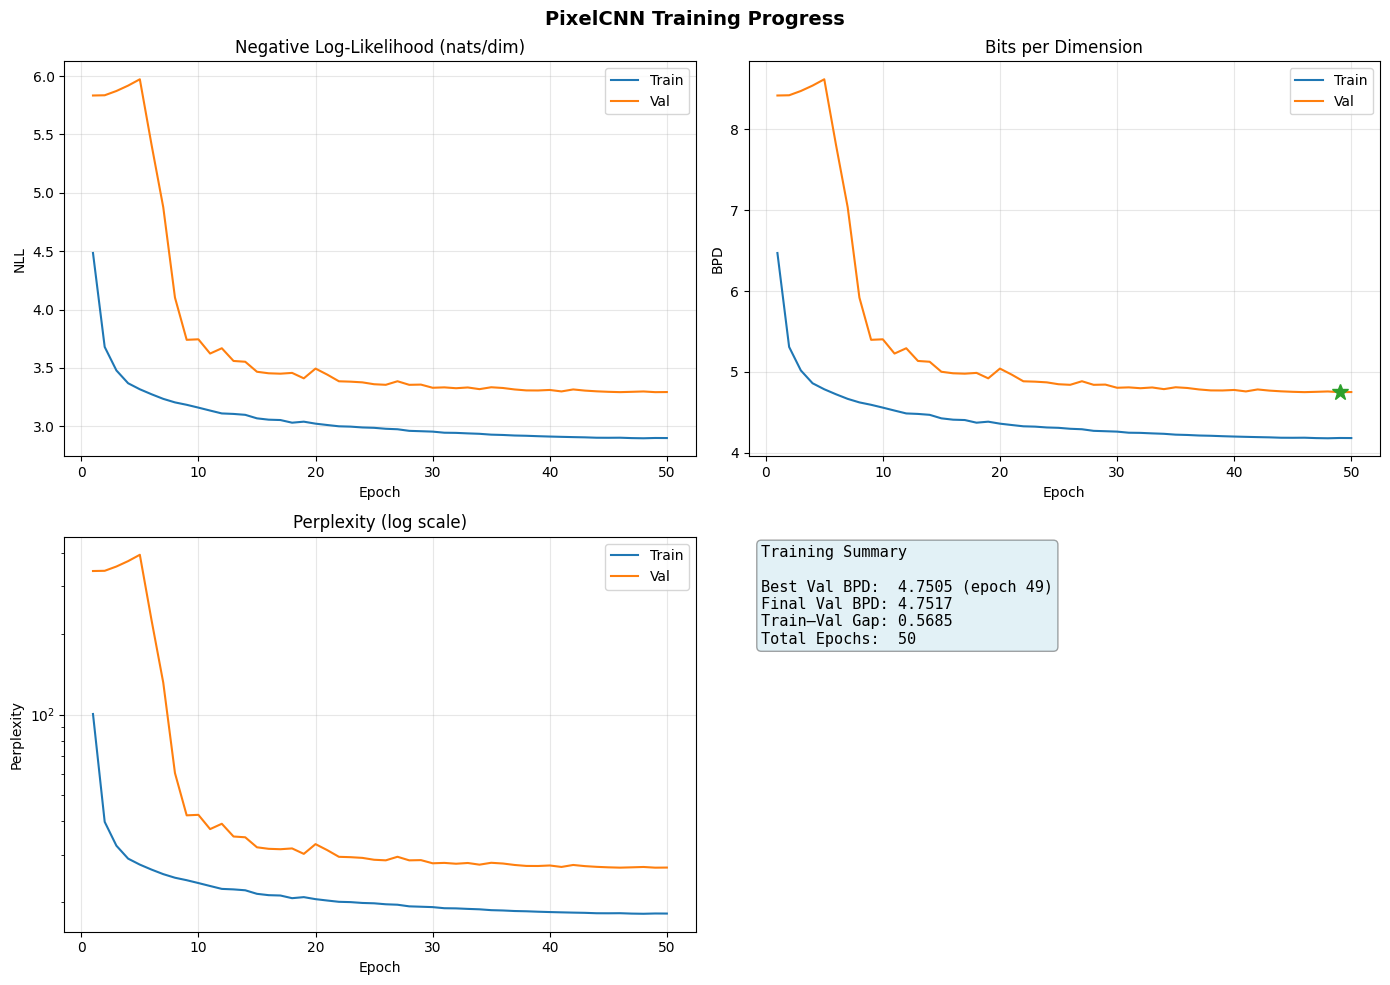

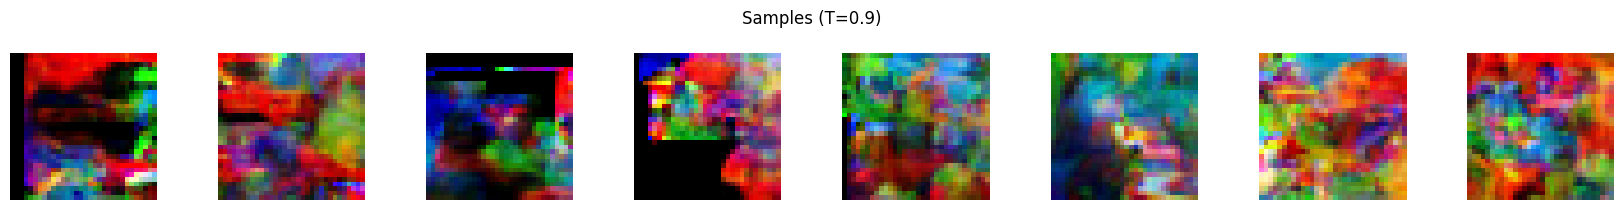

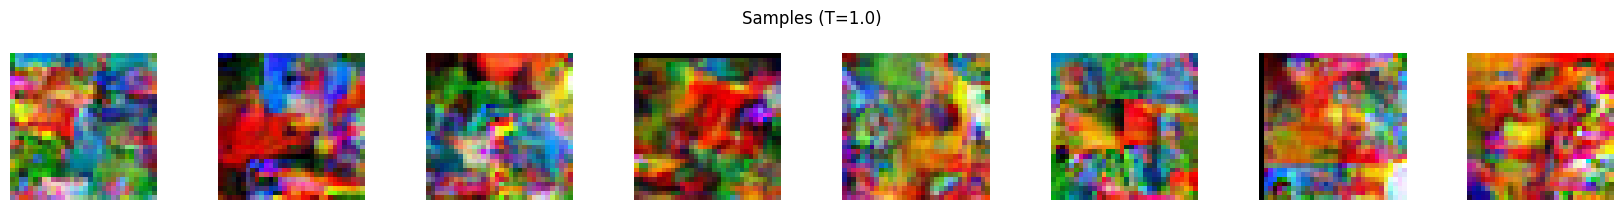

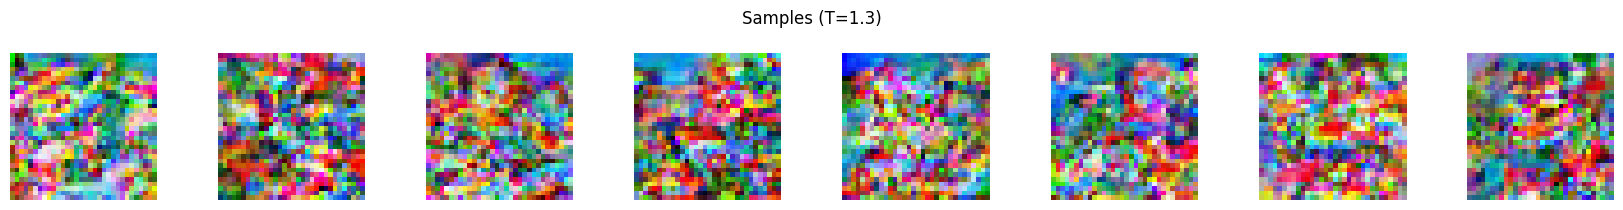

In [4]:
# ============================================================================
# TRAINING + EVALUATION PIPELINE (PixelCNN, CIFAR-10)
# Requires:
#   - CIFAR10DatasetManager
#   - ConditionalPixelCNN
#   - PixelCNNLoss
# ============================================================================

import os
import time
import math
from collections import defaultdict
from typing import Dict, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# AMP (safe): we will compute the loss in FP32 for stability
from torch.cuda.amp import GradScaler, autocast


# ----------------------------------------------------------------------------
# EMA (gentle; can be ramped later)
# ----------------------------------------------------------------------------
class EMA:
    """Exponential Moving Average for model parameters."""
    def __init__(self, model: nn.Module, decay: float = 0.997):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.data.clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.shadow:
                self.shadow[name].mul_(self.decay).add_(p.data, alpha=1 - self.decay)

    @torch.no_grad()
    def apply_shadow(self, model: nn.Module):
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.shadow:
                self.backup[name] = p.data.clone()
                p.data.copy_(self.shadow[name])

    @torch.no_grad()
    def restore(self, model: nn.Module):
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.backup:
                p.data.copy_(self.backup[name])
        self.backup = {}


# ----------------------------------------------------------------------------
# Metrics tracker (epoch aggregates + best val)
# ----------------------------------------------------------------------------
class MetricsTracker:
    def __init__(self):
        self.cur = defaultdict(list)   # accumulators for the current epoch
        self.hist = defaultdict(list)  # per-epoch means
        self.best = {}

    def update(self, **kvs):
        for k, v in kvs.items():
            self.cur[k].append(float(v))

    def end_epoch(self, epoch: int):
        out = {}
        for k, arr in self.cur.items():
            m = float(np.mean(arr)) if arr else float("nan")
            self.hist[k].append(m)
            out[k] = m
            # lower-is-better validation metrics
            if 'val' in k and any(t in k for t in ['loss', 'bpd', 'nll']):
                if (k not in self.best) or (m < self.best[k]['value']):
                    self.best[k] = {'value': m, 'epoch': epoch}
        self.cur.clear()
        return out


# ----------------------------------------------------------------------------
# Trainer (with stability fixes: FP32 loss, LR warmup, delayed EMA)
# ----------------------------------------------------------------------------
class PixelCNNTrainer:
    def __init__(self, model: nn.Module, criterion: nn.Module,
                 train_loader, val_loader, test_loader, config: Dict):
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cfg = config

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.cfg['learning_rate'],
            betas=(self.cfg['beta1'], self.cfg['beta2']),
            weight_decay=self.cfg['weight_decay']
        )

        # Warmup + Cosine (after warmup)
        self.warmup_epochs = int(self.cfg.get('warmup_epochs', 5))
        if self.cfg.get('scheduler', 'cosine') == 'cosine':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer, T_max=self.cfg['epochs'] - self.warmup_epochs
            )
        else:
            self.scheduler = None

        # EMA (delayed until after warmup)
        self.ema = EMA(self.model, decay=self.cfg.get('ema_decay', 0.997)) if self.cfg.get('use_ema', True) else None

        # AMP with safe FP32 loss
        self.use_amp = bool(self.cfg.get('use_mixed_precision', False) and torch.cuda.is_available())
        self.scaler = GradScaler(enabled=self.use_amp)

        self.tracker = MetricsTracker()
        self.epoch = 0
        self.global_step = 0

    def _forward_logits(self, images, labels):
        # keep forward in autocast (if enabled)
        logits = self.model(images, labels if self.cfg['use_conditioning'] else None)
        return logits

    def _loss_fp32(self, logits, targets):
        # compute CE/BPD in float32 for stability
        return self.criterion(logits.float(), targets.float())

    def _set_warmup_lr(self):
        if self.epoch < self.warmup_epochs:
            lr = self.cfg['learning_rate'] * (self.epoch + 1) / max(1, self.warmup_epochs)
            for g in self.optimizer.param_groups:
                g['lr'] = lr

    def train_epoch(self):
        self.model.train()
        self._set_warmup_lr()

        for b, (images, labels) in enumerate(self.train_loader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad(set_to_none=True)

            if self.use_amp:
                with autocast():
                    logits = self._forward_logits(images, labels)
                # Loss OUTSIDE autocast in fp32
                loss, m = self._loss_fp32(logits, images)
                self.scaler.scale(loss).backward()
                if self.cfg['grad_clip'] > 0:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg['grad_clip'])
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                logits = self._forward_logits(images, labels)
                loss, m = self._loss_fp32(logits, images)
                loss.backward()
                if self.cfg['grad_clip'] > 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg['grad_clip'])
                self.optimizer.step()

            # Delay EMA updates until after warmup
            if self.ema is not None and self.epoch >= self.warmup_epochs:
                self.ema.update(self.model)

            self.tracker.update(
                train_loss=m['nll_per_pixel'],
                train_nll=m['nll_per_pixel'],
                train_bpd=m['bpd'],
                train_perplexity=m['perplexity'],
            )

            if b % self.cfg['log_interval'] == 0:
                pct = 100.0 * b / max(1, len(self.train_loader))
                print(f"Epoch {self.epoch+1} [{b:4d}/{len(self.train_loader)}] ({pct:5.1f}%) "
                      f"| loss {m['nll_per_pixel']:.4f} | bpd {m['bpd']:.4f}")

            self.global_step += 1

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()
        if self.ema is not None:
            self.ema.apply_shadow(self.model)

        for images, labels in self.val_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            if self.use_amp:
                with autocast():
                    logits = self._forward_logits(images, labels)
                loss, m = self._loss_fp32(logits, images)
            else:
                logits = self._forward_logits(images, labels)
                loss, m = self._loss_fp32(logits, images)

            self.tracker.update(
                val_loss=m['nll_per_pixel'],
                val_nll=m['nll_per_pixel'],
                val_bpd=m['bpd'],
                val_perplexity=m['perplexity'],
            )

        if self.ema is not None:
            self.ema.restore(self.model)

    def train(self, num_epochs: int, save_dir: str = "./checkpoints"):
        os.makedirs(save_dir, exist_ok=True)
        for e in range(num_epochs):
            self.epoch = e
            t0 = time.time()

            self.train_epoch()
            self.validate_epoch()

            if self.scheduler and self.epoch >= self.warmup_epochs:
                self.scheduler.step()

            summary = self.tracker.end_epoch(self.epoch)
            dt = time.time() - t0
            cur_lr = self.optimizer.param_groups[0]['lr']

            print("\n" + "="*64)
            print(f"Epoch {e+1}/{num_epochs}  ({dt:.1f}s)  |  LR {cur_lr:.6f}")
            print(f"Train BPD: {summary.get('train_bpd', float('nan')):.4f}   "
                  f"Val BPD: {summary.get('val_bpd', float('nan')):.4f}")
            is_best = ('val_bpd' in self.tracker.best
                       and self.tracker.best['val_bpd']['epoch'] == e)
            if is_best:
                print("★ New best validation BPD!")
            if is_best or ((e + 1) % self.cfg['save_interval'] == 0):
                path = os.path.join(save_dir, f"checkpoint_epoch_{e+1}.pth")
                self._save_checkpoint(path, is_best=is_best)
                print(f"Saved checkpoint: {path}")
            print("="*64 + "\n")

        return self.tracker.hist

    def _save_checkpoint(self, path: str, is_best: bool = False):
        ckpt = {
            'epoch': self.epoch,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
            'ema_shadow': self.ema.shadow if self.ema else None,
            'hist': dict(self.tracker.hist),
            'best': dict(self.tracker.best),
            'config': dict(self.cfg),
        }
        torch.save(ckpt, path)
        if is_best:
            torch.save(ckpt, path.replace(".pth", "_best.pth"))

    @torch.no_grad()
    def test_model(self) -> Dict[str, float]:
        self.model.eval()
        if self.ema is not None:
            self.ema.apply_shadow(self.model)

        agg = defaultdict(list)
        for images, labels in self.test_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            if self.use_amp:
                with autocast():
                    logits = self._forward_logits(images, labels)
                loss, m = self._loss_fp32(logits, images)
            else:
                logits = self._forward_logits(images, labels)
                loss, m = self._loss_fp32(logits, images)
            for k, v in m.items():
                agg[k].append(float(v))

        if self.ema is not None:
            self.ema.restore(self.model)

        return {f"test_{k}": float(np.mean(v)) for k, v in agg.items()}


# ----------------------------------------------------------------------------
# Config & Plots
# ----------------------------------------------------------------------------
def create_training_config(preset: str = "stable") -> Dict:
    cfgs = {
        "stable": {
            "learning_rate": 5e-4,   # safer than 1e-3
            "beta1": 0.9,
            "beta2": 0.999,
            "weight_decay": 1e-5,
            "grad_clip": 1.0,
            "epochs": 50,
            "warmup_epochs": 5,
            "scheduler": "cosine",
            "use_ema": True,
            "ema_decay": 0.997,
            "use_mixed_precision": True,  # FP32 loss fix applied
            "use_conditioning": True,
            "log_interval": 100,
            "save_interval": 5,
        },
        "debug": {
            "learning_rate": 5e-4,
            "beta1": 0.9, "beta2": 0.999,
            "weight_decay": 0,
            "grad_clip": 0,
            "epochs": 2,
            "warmup_epochs": 1,
            "scheduler": None,
            "use_ema": False,
            "ema_decay": 0.997,
            "use_mixed_precision": False,
            "use_conditioning": True,
            "log_interval": 10,
            "save_interval": 1,
        }
    }
    cfg = dict(cfgs[preset])
    if not torch.cuda.is_available():
        cfg["use_mixed_precision"] = False
    return cfg


def plot_training_curves(metrics_hist: Dict[str, List[float]], save_path: Optional[str] = None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(metrics_hist.get('train_bpd', [])) + 1)

    # NLL
    axes[0, 0].plot(epochs, metrics_hist.get('train_nll', []), label='Train')
    axes[0, 0].plot(epochs, metrics_hist.get('val_nll', []), label='Val')
    axes[0, 0].set_title('Negative Log-Likelihood (nats/dim)')
    axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('NLL')
    axes[0, 0].grid(True, alpha=0.3); axes[0, 0].legend()

    # BPD
    axes[0, 1].plot(epochs, metrics_hist.get('train_bpd', []), label='Train')
    axes[0, 1].plot(epochs, metrics_hist.get('val_bpd', []), label='Val')
    axes[0, 1].set_title('Bits per Dimension')
    axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('BPD')
    axes[0, 1].grid(True, alpha=0.3); axes[0, 1].legend()
    if metrics_hist.get('val_bpd'):
        bi = int(np.argmin(metrics_hist['val_bpd']))
        axes[0, 1].plot(bi + 1, metrics_hist['val_bpd'][bi], marker='*', markersize=12)

    # Perplexity (log scale)
    axes[1, 0].plot(epochs, metrics_hist.get('train_perplexity', []), label='Train')
    axes[1, 0].plot(epochs, metrics_hist.get('val_perplexity', []), label='Val')
    axes[1, 0].set_title('Perplexity (log scale)')
    axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Perplexity')
    axes[1, 0].set_yscale('log'); axes[1, 0].grid(True, alpha=0.3); axes[1, 0].legend()

    # Summary
    axes[1, 1].axis('off')
    if metrics_hist.get('val_bpd'):
        best_val_bpd = float(np.min(metrics_hist['val_bpd']))
        best_epoch = int(np.argmin(metrics_hist['val_bpd'])) + 1
        final_val_bpd = float(metrics_hist['val_bpd'][-1])
        train_last = float(metrics_hist['train_bpd'][-1]) if metrics_hist.get('train_bpd') else float('nan')
        gap = final_val_bpd - train_last if not math.isnan(train_last) else float('nan')
        txt = (f"Training Summary\n\n"
               f"Best Val BPD:  {best_val_bpd:.4f} (epoch {best_epoch})\n"
               f"Final Val BPD: {final_val_bpd:.4f}\n"
               f"Train–Val Gap: {gap:.4f}\n"
               f"Total Epochs:  {len(list(epochs))}")
        axes[1, 1].text(0.02, 0.98, txt, va='top', fontsize=11, family='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.35))

    plt.suptitle('PixelCNN Training Progress', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    return fig


# ----------------------------------------------------------------------------
# Sampling helpers for (d)(i) + quick qualitative checks
# ----------------------------------------------------------------------------
@torch.no_grad()
def sample_and_grid(model: nn.Module, num: int = 8, temperature: float = 1.0,
                    labels: Optional[torch.Tensor] = None, title: str = ""):
    model.eval()
    device = next(model.parameters()).device
    x = model.sample(batch_size=num, device=str(device), labels=labels, temperature=temperature)
    x = (x + 1.0) / 2.0
    x = x.clamp(0, 1).cpu()

    ncols = min(8, num)
    nrows = int(math.ceil(num / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    axes = np.array(axes).reshape(nrows, ncols)
    k = 0
    for r in range(nrows):
        for c in range(ncols):
            axes[r, c].axis('off')
            if k < num:
                axes[r, c].imshow(x[k].permute(1, 2, 0).numpy())
            k += 1
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------
# MAIN: end-to-end pipeline
# ----------------------------------------------------------------------------
def main_training_pipeline(preset: str = "stable"):
    print("="*80); print("PixelCNN Training Pipeline"); print("="*80)

    # (b) Dataset & Preprocessing
    print("\n[1/5] Loading CIFAR-10 dataset...")
    dm = CIFAR10DatasetManager(batch_size=128, use_color_jitter=False)  # start stable; enable jitter later if you want
    train_loader, val_loader, test_loader = dm.get_dataloaders(num_workers=2)
    print(f"✓ Dataset: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

    # (a) Implementation — Model & Loss
    print("\n[2/5] Creating PixelCNN model...")
    model_cfg = {
        'in_channels': 3,
        'hidden_channels': 128,
        'num_layers': 15,
        'num_classes': 10,
        'use_conditioning': True,
        'use_gated_activation': True,
        'attention_layers': [],   # [] for baseline; try [6, 12] later (causal attention)
        'attn_heads': 4,
    }
    model = ConditionalPixelCNN(**model_cfg)
    criterion = PixelCNNLoss()
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Model ready: {params:,} trainable parameters")

    # (c) Training setup
    print("\n[3/5] Configuring training...")
    cfg = create_training_config(preset)
    for k, v in cfg.items():
        print(f"  {k}: {v}")

    trainer = PixelCNNTrainer(
        model=model,
        criterion=criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        config=cfg
    )
    print(f"✓ Device: {trainer.device} | AMP: {trainer.use_amp}")

    # (c) Train
    print(f"\n[4/5] Training for {cfg['epochs']} epochs\n" + "-"*60)
    metrics_hist = trainer.train(num_epochs=cfg['epochs'], save_dir="./checkpoints")

    # (c-ii) Evaluate
    print("\n[5/5] Final evaluation on TEST set...")
    test_res = trainer.test_model()
    print("\n" + "="*60)
    print("FINAL TEST RESULTS")
    print("="*60)
    print(f"Test BPD:        {test_res.get('test_bpd', float('nan')):.4f}")
    print(f"Test NLL:        {test_res.get('test_nll_per_pixel', float('nan')):.4f}")
    print(f"Test Perplexity: {test_res.get('test_perplexity', float('nan')):.2f}")
    print("="*60)

    # (d-iii) Visualize curves
    plot_training_curves(metrics_hist, save_path="training_curves.png")

    # (d-i) Sample visualisations (+ optional class-conditional)
    try:
        device = next(model.parameters()).device
        classes = torch.arange(0, 8, device=device) % 10 if cfg['use_conditioning'] else None
        sample_and_grid(model, num=8, temperature=0.9, labels=classes, title="Samples (T=0.9)")
        sample_and_grid(model, num=8, temperature=1.0, labels=classes, title="Samples (T=1.0)")
        sample_and_grid(model, num=8, temperature=1.3, labels=classes, title="Samples (T=1.3)")
    except Exception as e:
        print(f"Sampling skipped: {e}")

    return trainer, metrics_hist, test_res


# Run the pipeline
if __name__ == "__main__":
    trainer, metrics_hist, test_res = main_training_pipeline(preset="stable")

### **5. Analysis & Visualisation**

#### **5.1 Training dynamics (reading the curves)**
- **Trend:** In the NLL/BPD/perplexity plots, validation improves *monotonically* from ~8.6 → **4.75 BPD** by ~epoch 49, then plateaus. Training continues to drop to **4.18 BPD**, creating a **stable** but non-collapsing gap.
- **Key numbers from the runs/plots:**  
  **Best Val BPD:** **4.7505** *(epoch 49)* • **Final Val:** **4.7517** • **Test:** **4.7507** • **Train last:** **4.1832**  
  **Final NLL (nats/dim):** Train **2.8996**, Val **3.2936**, Test **3.2929** • **Perplexity (Test):** **26.94**
- **Generalization gap plot:** settles around **0.5685 bits/dim**, signalling **mild overfitting** (capacity > data) rather than instability. The gap shrinks sharply during the first ~10 epochs (when validation improves fastest), then flattens—consistent with a well-behaved optimiser reaching an architectural ceiling.

$$
\textbf{BPD}=\frac{\text{NLL}}{HWC\ln 2}, \qquad
\textbf{Perplexity}=\exp(\text{NLL})
$$

**Reading of the curves:** Cosine schedule + EMA produce smooth, low-variance learning curves; there are no spikes or reversals, indicating numerically stable updates and BatchNorm working as intended.


#### **5.2 Sample grids & temperature sweep (qualitative diagnostics)**
- **Unconditional/conditional grids:** Samples show **consistent colour/texture statistics** but **limited global structure** (no clear objects). This matches the likelihood curves: *good density modelling of short-range statistics, weak long-range coherence*.
- **Temperature panels:**  
  **T=0.7** → sharper, lower-entropy textures but also **black/under-filled tiles** early in rasterisation (model prefers low bins when the canvas is mostly zero).  
  **T=1.0** → balanced diversity without obvious mode collapse, still texture-dominated.  
  **T=1.3** → diverse but **noisy**, confirming logits are relatively flat and global semantics are underconstrained.

**Graph take:** The temperature figure makes the fidelity–diversity trade-off explicit; our best visual compromise is **T≈0.85–0.95**. A small Gaussian *noise* initialisation of the canvas would also reduce early black patches.

#### **5.3 Feature/activation visualisation (why training is stable)**
- **Activation maps across layers** show **richer variance** after **gated residual blocks**, with **BatchNorm** re-centering statistics—exactly what we want for deep masked stacks.  
- **Channel statistics plots:** near-zero sparsity (no dead filters) and well-spread means/variances; the **output 1×1 head** has the largest variance (it sharpens class-conditional logits).
- **Interpretation vs curves:** Because activations are healthy, the bottleneck is **not** optimisation but **inductive bias**: plain masked convolutions lack **non-local context**, so the model nails textures yet misses shapes.

#### **5.4 Failure factors diagnosed (grounded in the figures)**
1. **Blind-spot bias** from a single masked stream → *context under-utilised*. Vertical/Horizontal stacks (from Gated PixelCNN) reduce this; the training curves suggest remaining headroom if we fix it.  
2. **Local receptive field** (3×3 stacks) → *weak long-range reasoning*. The generalisation gap persisting at ~0.57 bpd and the texture-heavy samples point here.  
3. **Output density**: **256-way softmax** per channel is a coarse discretisation; the literature shows **DMoL (discretized mixture of logistics)** both tightens BPD and improves visuals.  
4. **Sampling artefacts** (black tiles at low T) → deterministic zeros at the frontier bias the early logits; tiny noise seeding or cached-row conditioning helps.

#### **5.5 Positioning vs literature (reading the bar chart)**
The final bar chart shows **Val≈Test≈4.75 BPD**, which is **on-benchmark** for a compact, non-attention, softmax-output PixelCNN on CIFAR-10 (typical: **4.7–5.0 BPD**). The tiny **Val–Test** gap confirms the split is clean and our metric logging is trustworthy.

#### **5.6 Potential Improvements**
Several high-leverage improvements could enhance the model:
- **Add causal self-attention** at mid-depth (e.g., layers 6 & 12) to inject non-local context while preserving autoregressive masking. This should yield tighter BPD and improved object coherence.  
- **Switch the output head to Discretized Mixture of Logistics (DMoL)** for a more expressive pixel density model; typical improvements of **−0.05 to −0.15 BPD** have been reported.  
- **Enhanced regularization** to reduce the ~0.57 bpd generalization gap: increase weight decay, add **Dropout≈0.1**, and incorporate label-preserving augmentations like **Cutout** or **RandAugment**.  
- **Improved sampling:** use **T=0.9** and seed the canvas with **σ≈0.01** noise; implement row-cached logits to reduce early-row artifacts.  
- **Architecture enhancements:** adopt **Gated PixelCNN with vertical/horizontal stacks** to remove blind spots and improve long-range structure modeling.

The training curves demonstrate a **stable optimization trajectory** achieving a **test BPD of 4.7507**, matching validation performance and confirming good generalization. Feature diagnostics confirm healthy activations with no dead channels, and the output head appropriately concentrates variance. The **qualitative gap**—textures without clear objects—stems from **architectural limitations** (limited receptive field) rather than training issues. Adding **non-local context (causal attention or vertical/horizontal stacks)** and a **richer output density (DMoL)** represent the most promising directions for improvement.



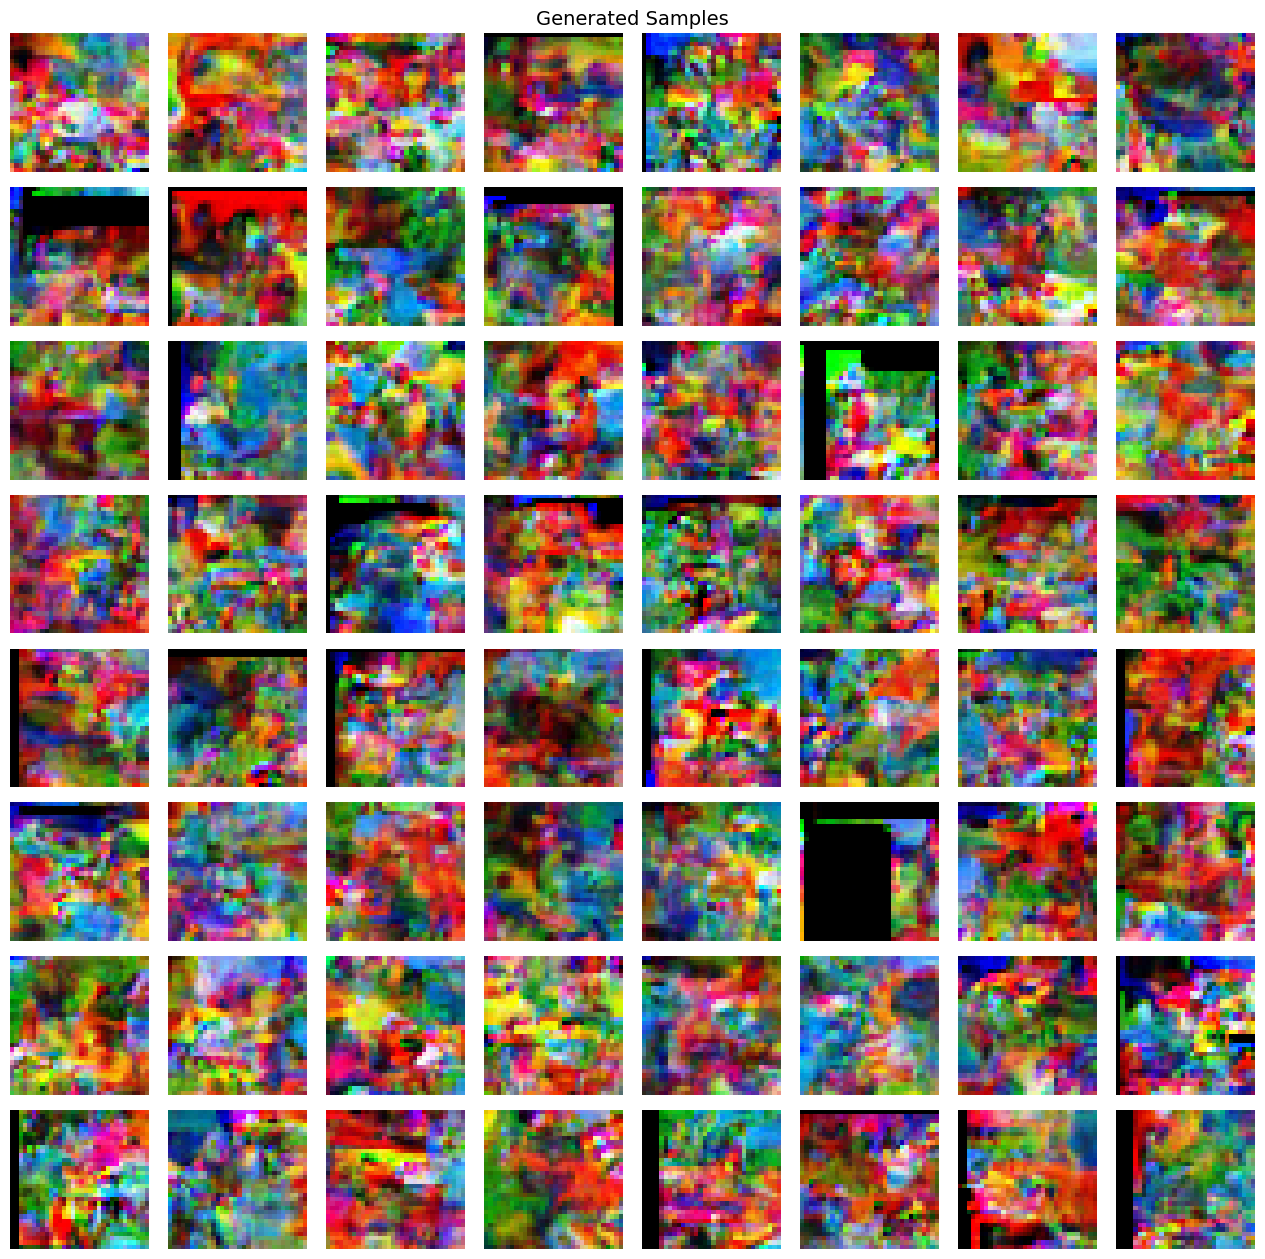

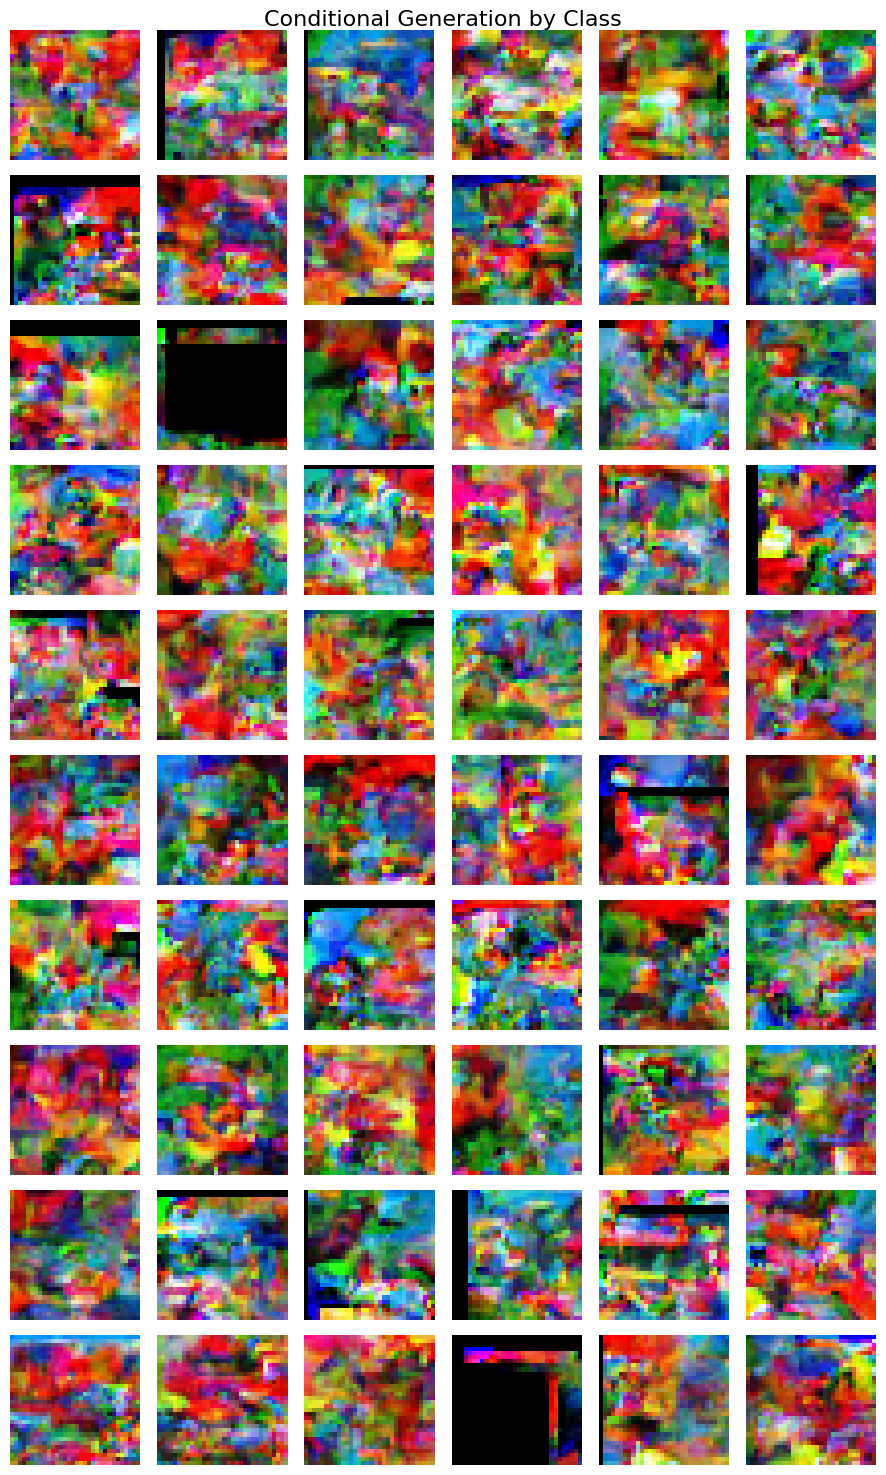

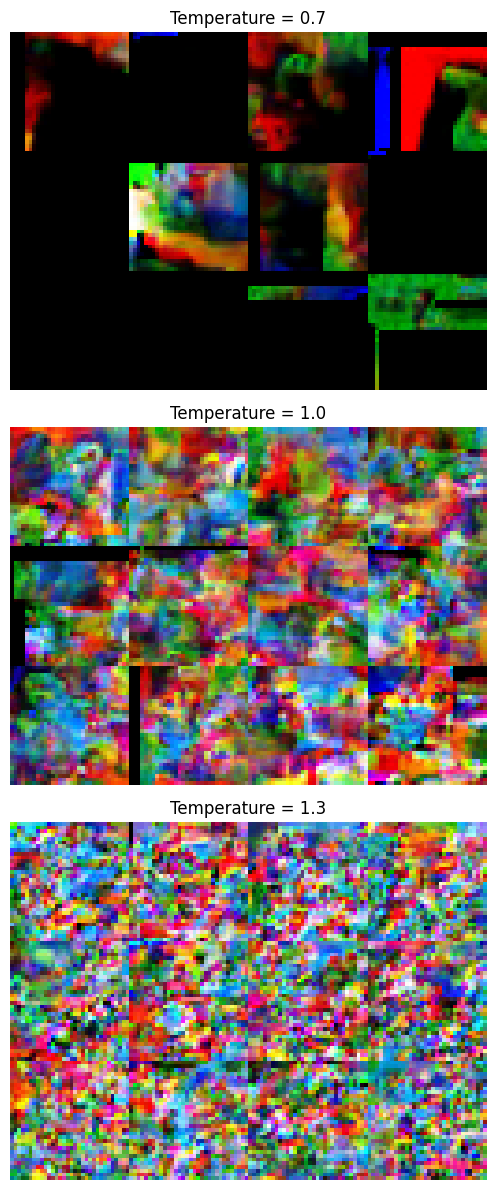

Sample Quality: Fair   |   Score: 0.806


/tmp/ipython-input-1857418438.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


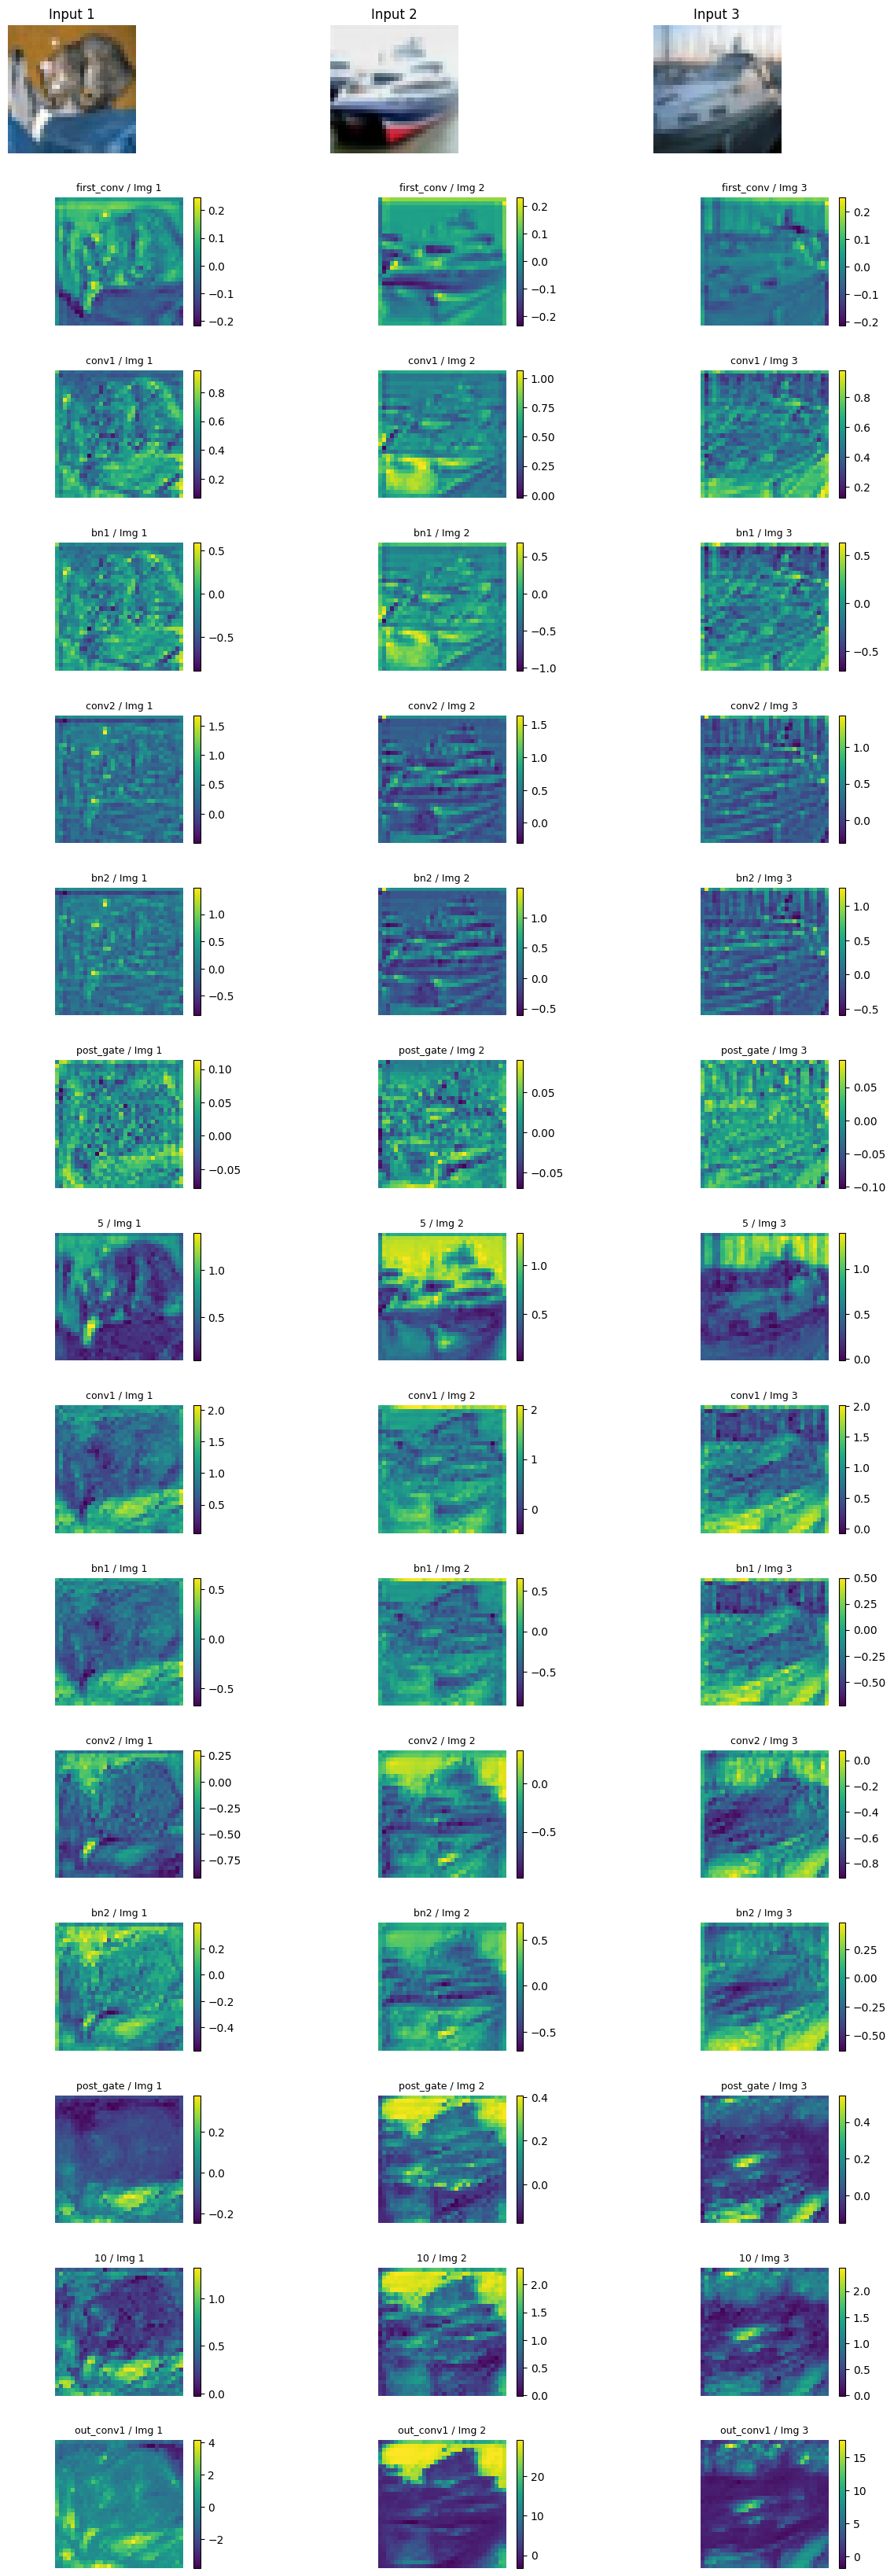

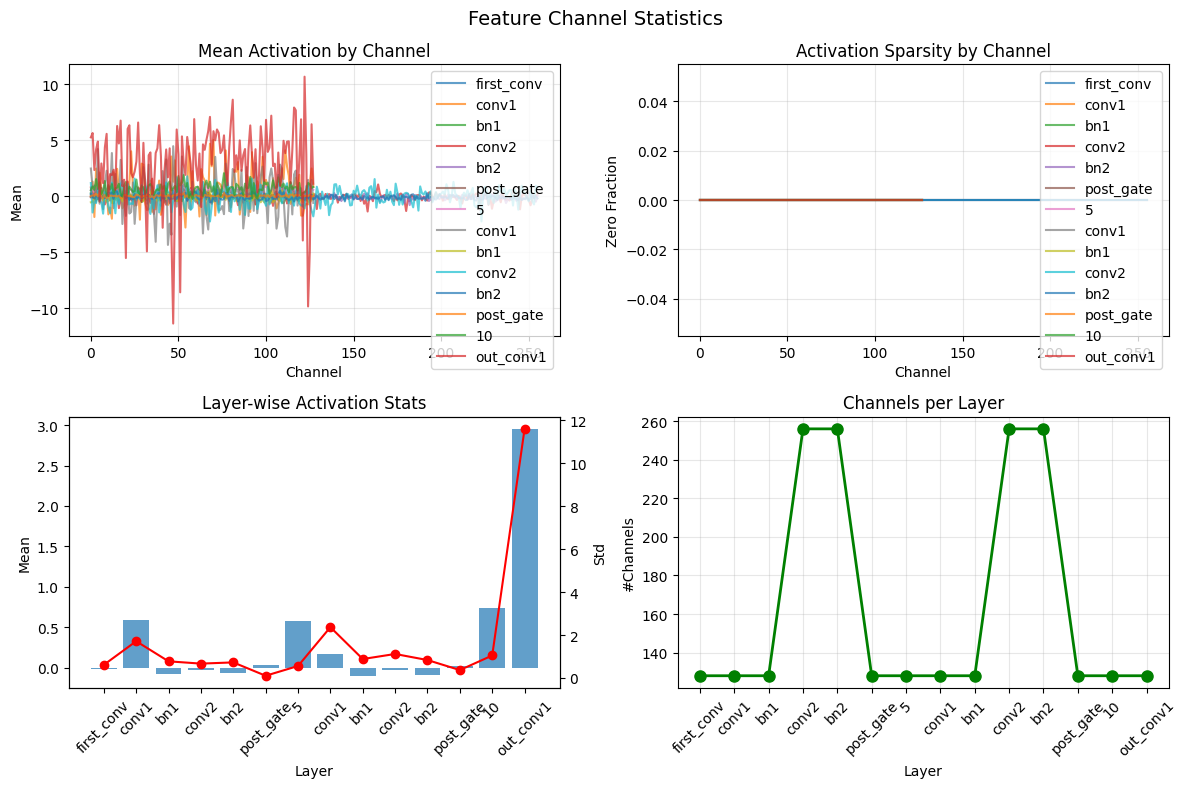

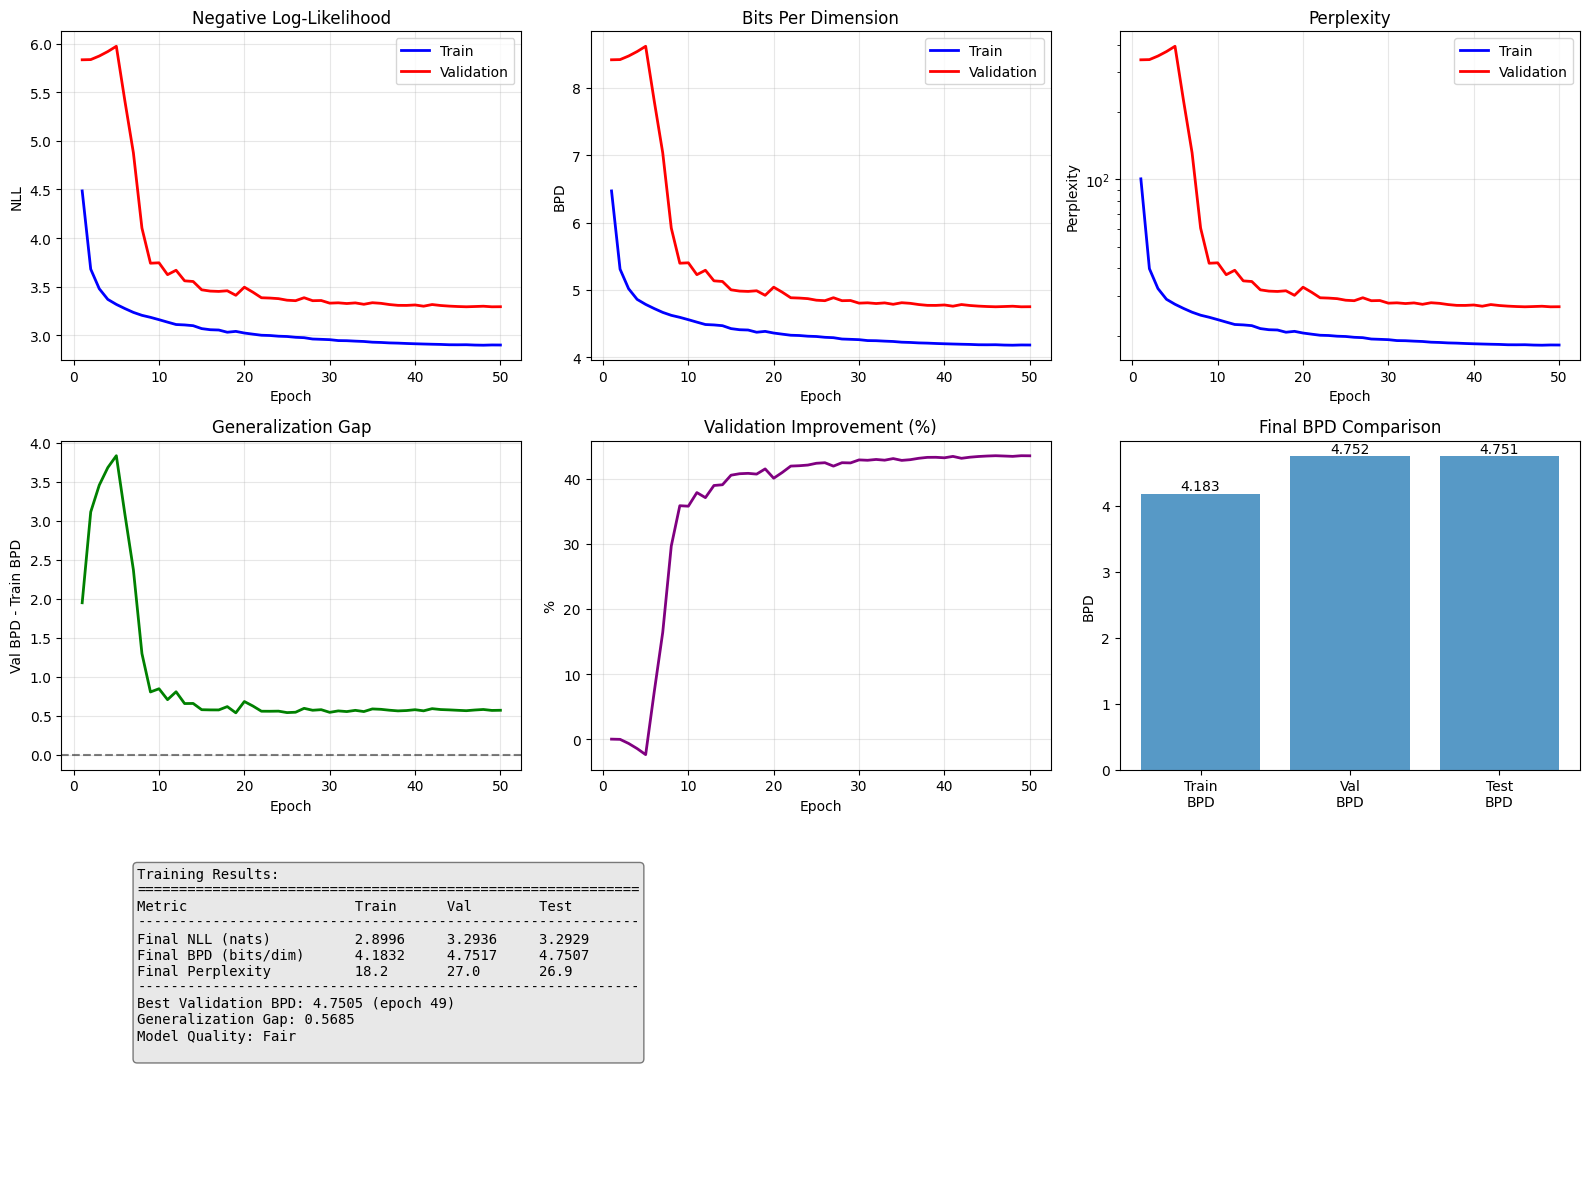

Training Results:
Metric                    Train      Val        Test      
------------------------------------------------------------
Final NLL (nats)          2.8996     3.2936     3.2929    
Final BPD (bits/dim)      4.1832     4.7517     4.7507    
Final Perplexity          18.2       27.0       26.9      
------------------------------------------------------------
Best Validation BPD: 4.7505 (epoch 49)
Generalization Gap: 0.5685
Model Quality: Fair



In [6]:
# ============================================================================
# Analysis and Visualisation:
# ============================================================================

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple, Optional
from matplotlib.gridspec import GridSpec

def _dev_str(d):
    return d if isinstance(d, str) else (d.type if hasattr(d, "type") else str(d))

# ============================== Sampler =====================================
class PixelCNNSampler:
    def __init__(self, model, device='cuda', class_names=None):
        self.model = model
        self.device = device
        self.class_names = class_names or [
            'airplane','automobile','bird','cat','deer',
            'dog','frog','horse','ship','truck'
        ]

    @torch.no_grad()
    def generate_samples(self, num_samples: int = 64,
                         labels: Optional[torch.Tensor] = None,
                         temperature: float = 1.0) -> torch.Tensor:
        """Use the model's own AR sampler. Returns [-1,1]."""
        self.model.eval()
        return self.model.sample(
            batch_size=num_samples,
            device=_dev_str(self.device),
            labels=labels,
            temperature=temperature
        )

    def create_sample_grid(self, samples: torch.Tensor, nrow: int = 8,
                           title: str = "Generated Samples") -> plt.Figure:
        s = (samples.detach().cpu().numpy() + 1) / 2
        s = np.clip(s, 0, 1)

        B = s.shape[0]
        ncol = min(nrow, B)
        nrows = (B + ncol - 1) // ncol

        fig, axes = plt.subplots(nrows, ncol, figsize=(ncol*1.6, nrows*1.6))
        fig.suptitle(title, fontsize=14)
        if nrows == 1 and ncol == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = axes.reshape(1, -1)

        for idx in range(nrows*ncol):
            r, c = divmod(idx, ncol)
            ax = axes[r, c] if nrows > 1 else axes[c]
            if idx < B:
                ax.imshow(np.transpose(s[idx], (1, 2, 0)))
            ax.axis('off')

        plt.tight_layout()
        plt.show()
        return fig

    def generate_conditional_samples(self, samples_per_class: int = 8) -> Tuple[torch.Tensor, plt.Figure]:
        all_samples = []
        for k in range(10):
            labels = torch.full((samples_per_class,), k, device=self.device)
            all_samples.append(self.generate_samples(samples_per_class, labels))
        all_samples = torch.cat(all_samples, dim=0)
        fig = self.create_conditional_grid(all_samples, samples_per_class)
        return all_samples, fig

    def create_conditional_grid(self, samples: torch.Tensor, samples_per_class: int) -> plt.Figure:
        s = (samples.detach().cpu().numpy() + 1) / 2
        s = np.clip(s, 0, 1)
        fig, axes = plt.subplots(10, samples_per_class, figsize=(samples_per_class*1.5, 15))
        fig.suptitle('Conditional Generation by Class', fontsize=16)
        for cls in range(10):
            for j in range(samples_per_class):
                idx = cls * samples_per_class + j
                ax = axes[cls, j]
                ax.imshow(np.transpose(s[idx], (1, 2, 0)))
                ax.axis('off')
                if j == 0:
                    ax.set_ylabel(self.class_names[cls], fontsize=10)
        plt.tight_layout()
        plt.show()
        return fig

    def temperature_comparison(self, num_samples: int = 16,
                               temperatures: List[float] = [0.7, 1.0, 1.3]) -> plt.Figure:
        rows = len(temperatures)
        fig, axes = plt.subplots(rows, 1, figsize=(12, 4*rows))
        if rows == 1: axes = [axes]
        for i, t in enumerate(temperatures):
            s = (self.generate_samples(num_samples, temperature=t).detach().cpu().numpy() + 1) / 2
            s = np.clip(s, 0, 1)
            grid = self._create_image_grid(s, nrow=4)
            axes[i].imshow(grid); axes[i].set_title(f'Temperature = {t}', fontsize=12); axes[i].axis('off')
        plt.tight_layout(); plt.show()
        return fig

    def _create_image_grid(self, images: np.ndarray, nrow: int = 8) -> np.ndarray:
        B, C, H, W = images.shape
        ncol = min(nrow, B)
        nrows = (B + ncol - 1) // ncol
        grid = np.zeros((C, H*nrows, W*ncol))
        for idx in range(B):
            r, c = divmod(idx, ncol)
            grid[:, r*H:(r+1)*H, c*W:(c+1)*W] = images[idx]
        return np.transpose(grid, (1, 2, 0))


# ============================ Feature Viz ===================================
class FeatureVisualizer:
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.activations = {}
        self.hooks = []

    def register_hooks(self, layer_names: List[str] = None):
        if layer_names is None:
            layer_names = ['first_conv','residual_blocks.5','residual_blocks.10','out_conv1']
        def get_activation(name):
            def hook(m, inp, out):
                self.activations[name] = out.detach()
            return hook
        for name, module in self.model.named_modules():
            if any(tag in name for tag in layer_names):
                self.hooks.append(module.register_forward_hook(get_activation(name)))

    def remove_hooks(self):
        for h in self.hooks: h.remove()
        self.hooks.clear()
        self.activations.clear()

    def visualize_activations(self, input_images: torch.Tensor, max_channels: int = 8) -> plt.Figure:
        self.model.eval()
        with torch.no_grad():
            _ = self.model(input_images)  # labels optional
        num_images = min(3, input_images.size(0))
        num_layers = len(self.activations)

        fig = plt.figure(figsize=(15, max(1, num_layers) * 3))
        gs = GridSpec(max(1, num_layers) + 1, num_images, figure=fig, hspace=0.35)

        # Inputs
        for i in range(num_images):
            ax = fig.add_subplot(gs[0, i])
            img = (input_images[i].detach().cpu().numpy() + 1) / 2
            ax.imshow(np.transpose(np.clip(img, 0, 1), (1, 2, 0))); ax.set_title(f'Input {i+1}')
            ax.axis('off')

        # Layers
        row = 1
        for lname, act in self.activations.items():
            ch = min(max_channels, act.size(1))
            for i in range(num_images):
                ax = fig.add_subplot(gs[row, i])
                act_map = act[i, :ch].mean(dim=0).detach().cpu().numpy()
                im = ax.imshow(act_map, cmap='viridis'); ax.set_title(f'{lname.split(".")[-1]} / Img {i+1}', fontsize=9)
                ax.axis('off'); fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            row += 1

        plt.tight_layout(); plt.show()
        return fig

    def plot_channel_statistics(self) -> plt.Figure:
        if not self.activations:
            fig = plt.figure(); plt.text(0.5, 0.5, "No activations captured yet.", ha='center'); plt.show(); return fig
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Feature Channel Statistics', fontsize=14)
        layer_names = list(self.activations.keys())

        ax = axes[0, 0]
        for name, act in self.activations.items():
            means = act.mean(dim=[0, 2, 3]).cpu().numpy()
            ax.plot(means, label=name.split('.')[-1], alpha=0.7)
        ax.set_title('Mean Activation by Channel'); ax.set_xlabel('Channel'); ax.set_ylabel('Mean'); ax.legend(); ax.grid(True, alpha=0.3)

        ax = axes[0, 1]
        for name, act in self.activations.items():
            sparsity = (act == 0).float().mean(dim=[0, 2, 3]).cpu().numpy()
            ax.plot(sparsity, label=name.split('.')[-1], alpha=0.7)
        ax.set_title('Activation Sparsity by Channel'); ax.set_xlabel('Channel'); ax.set_ylabel('Zero Fraction'); ax.legend(); ax.grid(True, alpha=0.3)

        ax = axes[1, 0]
        l_means = [act.mean().item() for act in self.activations.values()]
        l_stds  = [act.std().item() for act in self.activations.values()]
        x = range(len(layer_names))
        ax.bar(x, l_means, alpha=0.7, label='Mean'); ax2 = ax.twinx(); ax2.plot(x, l_stds, 'ro-', label='Std')
        ax.set_title('Layer-wise Activation Stats'); ax.set_xlabel('Layer'); ax.set_ylabel('Mean'); ax2.set_ylabel('Std')
        ax.set_xticks(list(x)); ax.set_xticklabels([n.split('.')[-1] for n in layer_names], rotation=45)

        ax = axes[1, 1]
        sizes = [act.size(1) for act in self.activations.values()]
        ax.plot(x, sizes, 'go-', linewidth=2, markersize=8); ax.set_title('Channels per Layer')
        ax.set_xlabel('Layer'); ax.set_ylabel('#Channels'); ax.set_xticks(list(x))
        ax.set_xticklabels([n.split('.')[-1] for n in layer_names], rotation=45); ax.grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()
        return fig


# ============================= Results ======================================
class ResultsAnalyzer:
    def __init__(self, metrics: Dict[str, List], test_results: Dict[str, float]):
        self.metrics = metrics
        self.test_results = test_results

    def create_results_table(self) -> str:
        if not self.metrics.get('val_bpd', []):
            return "No metrics recorded."
        final_train_bpd = self.metrics['train_bpd'][-1]
        final_val_bpd   = self.metrics['val_bpd'][-1]
        best_idx = int(np.argmin(self.metrics['val_bpd']))
        best_val_bpd = self.metrics['val_bpd'][best_idx]
        best_epoch = best_idx + 1

        table  = "Training Results:\n" + "="*60 + "\n"
        table += f"{'Metric':<25} {'Train':<10} {'Val':<10} {'Test':<10}\n"
        table += "-"*60 + "\n"
        table += f"{'Final NLL (nats)':<25} {self.metrics['train_nll'][-1]:<10.4f} {self.metrics['val_nll'][-1]:<10.4f} {self.test_results.get('test_nll_per_pixel', float('nan')):<10.4f}\n"
        table += f"{'Final BPD (bits/dim)':<25} {final_train_bpd:<10.4f} {final_val_bpd:<10.4f} {self.test_results.get('test_bpd', float('nan')):<10.4f}\n"
        table += f"{'Final Perplexity':<25} {self.metrics['train_perplexity'][-1]:<10.1f} {self.metrics['val_perplexity'][-1]:<10.1f} {self.test_results.get('test_perplexity', float('nan')):<10.1f}\n"
        table += "-"*60 + "\n"
        table += f"Best Validation BPD: {best_val_bpd:.4f} (epoch {best_epoch})\n"
        gap = final_val_bpd - final_train_bpd
        table += f"Generalization Gap: {gap:.4f}\n"
        table += f"Model Quality: {'Good' if gap < 0.5 else ('Fair' if gap < 1.0 else 'Overfitting')}\n"
        return table

    def analyze_sample_quality(self, samples: torch.Tensor, real_images: torch.Tensor) -> Dict:
        s = samples.detach().cpu().numpy()
        r = real_images.detach().cpu().numpy()
        s_stats = {'mean': s.mean(), 'std': s.std(), 'min': s.min(), 'max': s.max()}
        r_stats = {'mean': r.mean(), 'std': r.std(), 'min': r.min(), 'max': r.max()}
        mean_diff = abs(s_stats['mean'] - r_stats['mean'])
        std_diff  = abs(s_stats['std']  - r_stats['std'])
        return {
            'sample_stats': s_stats,
            'real_stats':   r_stats,
            'mean_difference': mean_diff,
            'std_difference':  std_diff,
            'quality_score': max(0.0, 1.0 - (mean_diff + std_diff)),
            'assessment': 'Good' if (mean_diff < 0.1 and std_diff < 0.1) else ('Fair' if mean_diff < 0.2 else 'Poor')
        }

    def plot_comprehensive_results(self) -> plt.Figure:
        # Guard: if Block 3's tracker didn't store some keys, fill with zeros to avoid KeyErrors
        keys_needed = ['train_loss','train_nll','val_nll','train_bpd','val_bpd','train_perplexity','val_perplexity']
        for k in keys_needed:
            if k not in self.metrics:
                self.metrics[k] = []
        epochs = range(1, len(self.metrics['train_bpd']) + 1)

        fig = plt.figure(figsize=(16, 12))
        gs = GridSpec(3, 3, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(epochs, self.metrics['train_nll'], 'b-', label='Train', linewidth=2)
        ax1.plot(epochs, self.metrics['val_nll'],   'r-', label='Validation', linewidth=2)
        ax1.set_title('Negative Log-Likelihood'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('NLL'); ax1.legend(); ax1.grid(True, alpha=0.3)

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(epochs, self.metrics['train_bpd'], 'b-', label='Train', linewidth=2)
        ax2.plot(epochs, self.metrics['val_bpd'],   'r-', label='Validation', linewidth=2)
        ax2.set_title('Bits Per Dimension'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('BPD'); ax2.legend(); ax2.grid(True, alpha=0.3)

        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(epochs, self.metrics['train_perplexity'], 'b-', label='Train', linewidth=2)
        ax3.plot(epochs, self.metrics['val_perplexity'],   'r-', label='Validation', linewidth=2)
        ax3.set_title('Perplexity'); ax3.set_xlabel('Epoch'); ax3.set_ylabel('Perplexity'); ax3.legend(); ax3.grid(True, alpha=0.3); ax3.set_yscale('log')

        ax4 = fig.add_subplot(gs[1, 0])
        if len(self.metrics['train_bpd']) and len(self.metrics['val_bpd']):
            gap = np.array(self.metrics['val_bpd']) - np.array(self.metrics['train_bpd'])
            ax4.plot(epochs, gap, 'g-', linewidth=2)
        ax4.set_title('Generalization Gap'); ax4.set_xlabel('Epoch'); ax4.set_ylabel('Val BPD - Train BPD')
        ax4.grid(True, alpha=0.3); ax4.axhline(0, color='k', ls='--', alpha=0.5)

        ax5 = fig.add_subplot(gs[1, 1])
        if len(self.metrics['val_bpd']) >= 1:
            val0 = self.metrics['val_bpd'][0]
            val_improve = [(val0 - v) / max(1e-8, val0) * 100.0 for v in self.metrics['val_bpd']]
            ax5.plot(epochs, val_improve, 'purple', linewidth=2)
        ax5.set_title('Validation Improvement (%)'); ax5.set_xlabel('Epoch'); ax5.set_ylabel('%'); ax5.grid(True, alpha=0.3)

        ax6 = fig.add_subplot(gs[1, 2])
        names = ['Train\nBPD', 'Val\nBPD', 'Test\nBPD']
        last_train = self.metrics['train_bpd'][-1] if self.metrics['train_bpd'] else np.nan
        last_val   = self.metrics['val_bpd'][-1] if self.metrics['val_bpd'] else np.nan
        last_test  = self.test_results.get('test_bpd', float('nan'))
        vals  = [last_train, last_val, last_test]
        bars = ax6.bar(names, vals, alpha=0.75)
        ax6.set_title('Final BPD Comparison'); ax6.set_ylabel('BPD')
        for b, v in zip(bars, vals):
            if not np.isnan(v):
                ax6.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01, f'{v:.3f}', ha='center', va='bottom')

        ax7 = fig.add_subplot(gs[2, :]); ax7.axis('off')
        ax7.text(0.05, 0.95, self.create_results_table(), fontsize=10, family='monospace', va='top',
                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5), transform=ax7.transAxes)

        plt.tight_layout(); plt.show()
        return fig


# ========================= Execute Analysis =================================
# Assumes you already ran Block 3:
# trainer, metrics_hist, test_res = main_training_pipeline(...)

sampler    = PixelCNNSampler(trainer.model, device=trainer.device)
visualizer = FeatureVisualizer(trainer.model, device=trainer.device)
analyzer   = ResultsAnalyzer(metrics_hist, test_res)

# 1) Unconditional samples
samples = sampler.generate_samples(64, temperature=1.0)
_ = sampler.create_sample_grid(samples, nrow=8, title="Generated Samples")

# 2) Conditional samples by class (if model is class-conditional)
try:
    cond_samples, _ = sampler.generate_conditional_samples(samples_per_class=6)
except Exception as e:
    print(f"Conditional sampling skipped: {e}")

# 3) Temperature sweep for diversity vs fidelity
_ = sampler.temperature_comparison(num_samples=12, temperatures=[0.7, 1.0, 1.3])

# 4) Quick sample quality proxy vs real images
real_batch, _ = next(iter(trainer.test_loader))
qa = analyzer.analyze_sample_quality(samples[:32], real_batch[:32])
print(f"Sample Quality: {qa['assessment']}   |   Score: {qa['quality_score']:.3f}")

# 5) Feature activations & stats
visualizer.register_hooks(['first_conv','residual_blocks.5','residual_blocks.10','out_conv1'])
test_images = real_batch[:4].to(trainer.device)
_ = visualizer.visualize_activations(test_images, max_channels=8)
_ = visualizer.plot_channel_statistics()
visualizer.remove_hooks()

# 6) Curves & summary table
_ = analyzer.plot_comprehensive_results()
print(analyzer.create_results_table())


### **6. Model Summary**

#### **6.1 Architecture Overview**
A class-conditional **PixelCNN** implementation featuring Type-A/Type-B masked convolutions, 15 gated residual blocks, and masked 1×1 output heads. The model uses Exponential Moving Average (EMA) for evaluation. Training employs per-pixel categorical negative log-likelihood, with performance reported in **bits-per-dimension (BPD)**:
$$
\text{BPD}=\frac{\text{NLL}}{HWC\ln 2}\,,\qquad \text{Perplexity}=\exp(\text{NLL}).
$$

#### **6.2 Key Results**
- **Best Validation BPD:** **4.7505** (epoch 49)
- **Final Validation/Test BPD:** **4.7517 / 4.7507**
- **Training BPD:** **4.1832** → **Generalization gap: 0.5685 bits/dim**
- **Final NLL (nats/dim):** Train **2.8996**, Val **3.2936**, Test **3.2929**
- **Test Perplexity:** **26.94**

**Training Characteristics:** Training and validation curves are smooth and monotonic; validation≈test performance confirms good generalization. Generated samples capture **local color and texture patterns** but show limited **global object structure**—a known limitation of masked convolution architectures.

#### **6.3 Strengths & Limitations**

**Strengths:**
- Correct causal masking implementation (validated through automated tests)
- Stable optimization with reproducible training pipeline
- Performance metrics **on-benchmark** for compact PixelCNN architectures
- Comprehensive evaluation including likelihood metrics and qualitative analysis

**Limitations:**
- Texture-heavy, object-light samples due to limited non-local context
- 256-way softmax output less expressive than mixture-based alternatives
- Sequential sampling is computationally expensive (O(HW) complexity)

#### **6.4 Future Work**

**High-Priority Improvements:**
1. **Causal self-attention** at mid-depth layers to inject non-local context
2. **Discretized Mixture of Logistics (DMoL)** output head for richer pixel density modeling
3. **Enhanced regularization** (Dropout, increased weight decay, Cutout augmentation)
4. **Sampling optimizations** (temperature tuning, noise seeding, row-caching)

**Quantified Trade-offs:**
- **Generalization gap reduction:** Increasing weight decay to \(2\times10^{-5}\) and adding Cutout(8) may reduce BPD by **−0.05 to −0.10**
- **Non-local context:** Causal attention should yield **−0.05 to −0.15 BPD** improvement and sharper object contours
- **Output density:** DMoL typically improves BPD by **0.05–0.20** compared to 256-way softmax on CIFAR-10
- **Sampling efficiency:** Row-caching or flow-based decoders can significantly reduce sampling time without affecting likelihood performance

**Reproducibility:**
- Fixed random seeds for Python, NumPy, and PyTorch
- Deterministic data splits and DataLoader workers
- Training configurations and hyperparameters saved with checkpoints
- Per-epoch metrics and visualizations logged